In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import linregress
from scipy.stats import pearsonr
from scipy.stats import f_oneway, kruskal
from scipy.stats import shapiro, ttest_ind, mannwhitneyu
from statsmodels.distributions.empirical_distribution import ECDF

In [2]:
# Read in clean HG dataset with new madres data
cleaned_visits = pd.read_excel('May_2025/cleaned_visits_5.30.25.xlsx')

In [3]:
cleaned_visits.head()

,Other Notes,HG,Clinic,ID,Date,Visit_Number,TCF7L2,GDF15,IGFBP7,EGA_Weeks,...,HELP,PUQE,Prepregnancy_Weight,Current_Weight,Weight_Change_from_Prepregnancy,PUQE_Severity,HELP_Severity,Weight_Change_from_Last_Visit,Weight_Difference_from_Prepreg (%),Weight_Difference_from_Last
0,normal,no,madres,1065_WA03928,NaT,1,3461.341268,8839.392887,105294.697759,13.4286,...,NaN,4.0,145.025055,NaN,NaN,Low,Unknown,NaN,NaN,NaN
1,normal,no,madres,122_RH08462,NaT,1,3137.791124,27895.856937,104011.519071,13.8571,...,NaN,3.0,100.016595,NaN,NaN,Low,Unknown,NaN,NaN,NaN
2,hg,yes,madres,154_IN05817,NaT,1,86824.003245,17909.352716,110847.711827,11.5700,...,NaN,14.0,179.030000,NaN,NaN,High,Unknown,NaN,NaN,NaN
3,normal,no,madres,165_WD02107,NaT,1,3672.951842,10730.503904,155319.325818,12.2857,...,NaN,6.0,141.022980,NaN,NaN,Low,Unknown,NaN,NaN,NaN
4,normal,no,madres,186_CE07588,NaT,1,35513.496640,15229.454545,88817.509876,10.8571,...,NaN,3.0,149.024925,NaN,NaN,Low,Unknown,NaN,NaN,NaN


# EDA

## Madres Data

In [4]:
madres = cleaned_visits[cleaned_visits['Clinic'] == "madres"]
madres.head()
madres.columns

Index(['Other Notes', 'HG', 'Clinic', 'ID', 'Date', 'Visit_Number', 'TCF7L2',
       'GDF15', 'IGFBP7', 'EGA_Weeks', 'Race', 'HELP', 'PUQE',
       'Prepregnancy_Weight', 'Current_Weight',
       'Weight_Change_from_Prepregnancy', 'PUQE_Severity', 'HELP_Severity',
       'Weight_Change_from_Last_Visit', 'Weight_Difference_from_Prepreg (%)',
       'Weight_Difference_from_Last'],
      dtype='object')

In [5]:
# split madres data with hg and without hg
madres_normal = madres[madres['HG'] == 'no']
madres_hg = madres[madres['HG'] == 'yes']

## Helper Functions

In [6]:
# Function for boxplots to analyze various attribute distribution amongst those with and without HG
def dist_boxplot(df, col):
    sns.boxplot(data=df, x='HG', y=col, hue='HG', legend=False)
    plt.title(col + " by HG Status")

# Function to test for Statistical Significance in Difference between Sample Means
def perform_statistical_tests(data, group_column, value_column, group1, group2):
    """
    Perform statistical tests (normality tests and t-tests or Mann-Whitney U tests) between two groups.

    Parameters:
    - data: DataFrame containing the data.
    - group_column: Column name indicating the group (e.g., 'Race').
    - value_column: The column containing the values to test (e.g., 'IGFBP7').
    - group1: The first group to compare (e.g., 'black').
    - group2: The second group to compare (e.g., 'white').
    """
    # Filter and remove NaN values for both groups
    group1_data = data[data[group_column] == group1][value_column].dropna()
    group2_data = data[data[group_column] == group2][value_column].dropna()

    # Check the sample size
    if len(group1_data) < 3 or len(group2_data) < 3:
        print(f"Not enough data for statistical testing. {group1}: {len(group1_data)}, {group2}: {len(group2_data)}")
        return
    
    # Perform Shapiro-Wilk normality tests
    shapiro_group1 = stats.shapiro(group1_data)
    shapiro_group2 = stats.shapiro(group2_data)
    
    print(f"Shapiro-Wilk test for {group1} (n={len(group1_data)}): p-value = {shapiro_group1.pvalue}")
    print(f"Shapiro-Wilk test for {group2} (n={len(group2_data)}): p-value = {shapiro_group2.pvalue}")
    
    # Check if both groups are normally distributed
    if shapiro_group1.pvalue >= 0.05 and shapiro_group2.pvalue >= 0.05:
        print("Both groups are normally distributed. Performing t-tests.")
        
        # Perform Independent t-test (assuming equal variances)
        t_stat, p_value = stats.ttest_ind(group1_data, group2_data)
        print(f"Independent t-test result (n={len(group1_data)} vs. n={len(group2_data)}): t-statistic = {t_stat}, p-value = {p_value}")
        
        # Perform Welch's t-test if unequal variances are suspected
        t_stat_welch, p_value_welch = stats.ttest_ind(group1_data, group2_data, equal_var=False)
        print(f"Welch's t-test result (n={len(group1_data)} vs. n={len(group2_data)}): t-statistic = {t_stat_welch}, p-value = {p_value_welch}")
    
    else:
        print("At least one group is not normally distributed. Performing Mann-Whitney U test.")
        
        # Perform Mann-Whitney U test (non-parametric test)
        u_stat, p_value_mwu = stats.mannwhitneyu(group1_data, group2_data, alternative='two-sided')
        print(f"Mann-Whitney U test result (n={len(group1_data)} vs. n={len(group2_data)}): U-statistic = {u_stat}, p-value = {p_value_mwu}")

## Boxplot Distributions - Madres Only
* Keeping in mind limitation of small HG sample size n=7.

### PUQE by HG Status

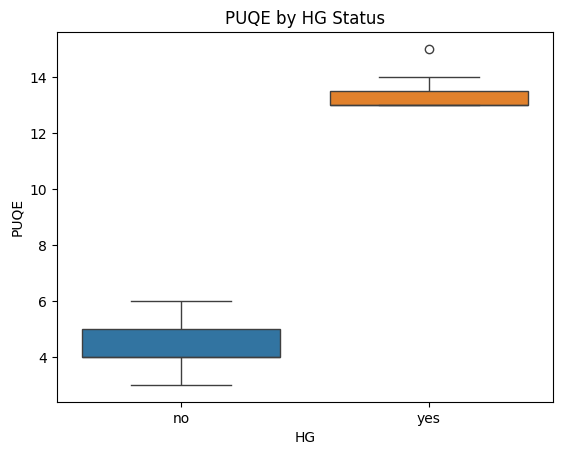

In [7]:
dist_boxplot(madres, 'PUQE')

#### Stat Sig - Yes (to be expected)

In [8]:
perform_statistical_tests(madres, "HG", "PUQE", 'yes', 'no')

Shapiro-Wilk test for yes (n=7): p-value = 0.0009314464717012313
Shapiro-Wilk test for no (n=32): p-value = 0.0014658277589733213
At least one group is not normally distributed. Performing Mann-Whitney U test.
Mann-Whitney U test result (n=7 vs. n=32): U-statistic = 224.0, p-value = 3.059679328193466e-05


### EGA by HG Status

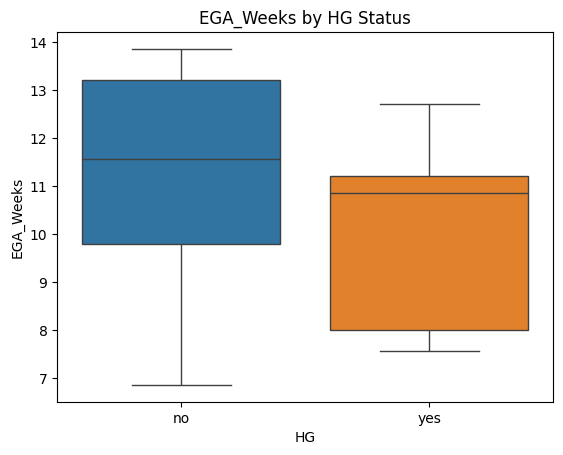

In [9]:
dist_boxplot(madres, 'EGA_Weeks')

#### Stat Sig - No

In [10]:
perform_statistical_tests(madres, "HG", "EGA_Weeks", 'yes', 'no')

Shapiro-Wilk test for yes (n=7): p-value = 0.2306132334510197
Shapiro-Wilk test for no (n=32): p-value = 0.018058365872542892
At least one group is not normally distributed. Performing Mann-Whitney U test.
Mann-Whitney U test result (n=7 vs. n=32): U-statistic = 66.0, p-value = 0.0955002784997617


### Prepregnancy Weight by HG Status

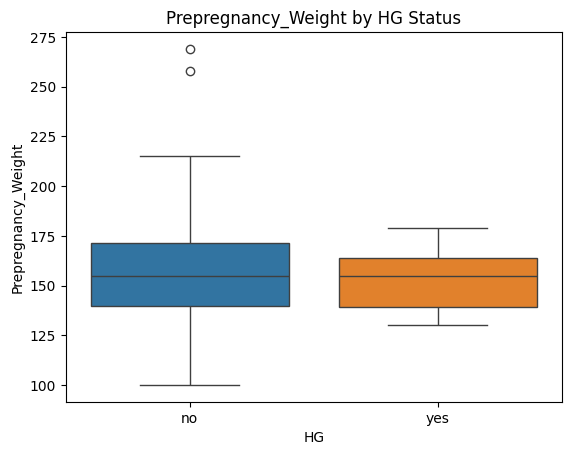

In [11]:
dist_boxplot(madres, 'Prepregnancy_Weight')

#### Stat Sig - No

In [12]:
perform_statistical_tests(madres, "HG", "Prepregnancy_Weight", 'yes', 'no')

Shapiro-Wilk test for yes (n=7): p-value = 0.7820986963403841
Shapiro-Wilk test for no (n=32): p-value = 0.002839808874140585
At least one group is not normally distributed. Performing Mann-Whitney U test.
Mann-Whitney U test result (n=7 vs. n=32): U-statistic = 103.0, p-value = 0.7556650004303852


### TCF7L2 by HG Status

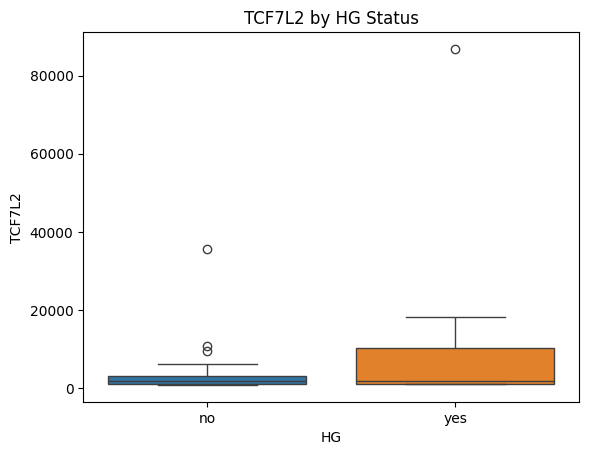

In [13]:
dist_boxplot(madres, 'TCF7L2')

#### Stat Sig - No

In [14]:
perform_statistical_tests(madres, "HG", "TCF7L2", 'yes', 'no')

Shapiro-Wilk test for yes (n=7): p-value = 0.00012186175531484656
Shapiro-Wilk test for no (n=32): p-value = 4.5283650383462794e-10
At least one group is not normally distributed. Performing Mann-Whitney U test.
Mann-Whitney U test result (n=7 vs. n=32): U-statistic = 127.0, p-value = 0.603257655889235


#### Look into TCF7L2 outlier in Madres Data for Patients with HG
* Not removing the outliers for patients without HG.

In [15]:
madres_hg[madres_hg['TCF7L2'] > 15000]

,Other Notes,HG,Clinic,ID,Date,Visit_Number,TCF7L2,GDF15,IGFBP7,EGA_Weeks,...,HELP,PUQE,Prepregnancy_Weight,Current_Weight,Weight_Change_from_Prepregnancy,PUQE_Severity,HELP_Severity,Weight_Change_from_Last_Visit,Weight_Difference_from_Prepreg (%),Weight_Difference_from_Last
2,hg,yes,madres,154_IN05817,NaT,1,86824.003245,17909.352716,110847.711827,11.5700,...,NaN,14.0,179.03,NaN,NaN,High,Unknown,NaN,NaN,NaN
8,hg,yes,madres,234_IL00110,NaT,1,18194.973502,8682.455324,104781.504733,7.8571,...,NaN,13.0,133.02,NaN,NaN,High,Unknown,NaN,NaN,NaN


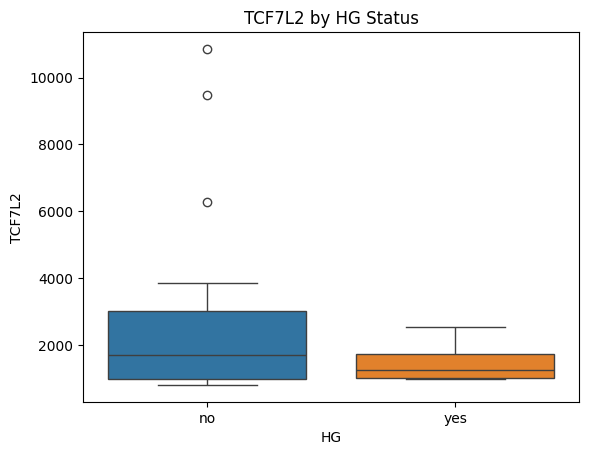

In [122]:
madres_tcf_outlier_removed = madres[madres['TCF7L2'] < 15250]
dist_boxplot(madres_tcf_outlier_removed, 'TCF7L2')

#### Stat Sig - No

In [123]:
perform_statistical_tests(madres_tcf_outlier_removed, "HG", "TCF7L2", 'yes', 'no')

Shapiro-Wilk test for yes (n=5): p-value = 0.19535453246415935
Shapiro-Wilk test for no (n=31): p-value = 1.0342060195722823e-06
At least one group is not normally distributed. Performing Mann-Whitney U test.
Mann-Whitney U test result (n=5 vs. n=31): U-statistic = 64.0, p-value = 0.5631737543502249


### Insights
* While there is no statistical significance, these results are consistent with hypothesis that TCF7L2 may serve as a protective feature of HG **when the outliers are removed**. Otherwise, the outliers skew the TCf7L2 distribution and increase the mean.
    * However, n=4 for patients with HG when outliers are removed (madres data only).

### GDF15 by HG Status

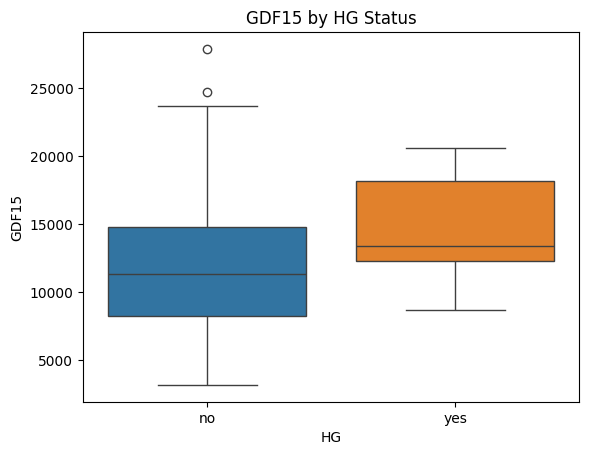

In [18]:
dist_boxplot(madres, 'GDF15')

#### Stat Sig - No

In [19]:
perform_statistical_tests(madres, "HG", "GDF15", 'yes', 'no')

Shapiro-Wilk test for yes (n=7): p-value = 0.7308156539847424
Shapiro-Wilk test for no (n=32): p-value = 0.016047639051325523
At least one group is not normally distributed. Performing Mann-Whitney U test.
Mann-Whitney U test result (n=7 vs. n=32): U-statistic = 149.0, p-value = 0.18588204346718282


### IGFBP7 by HG Status

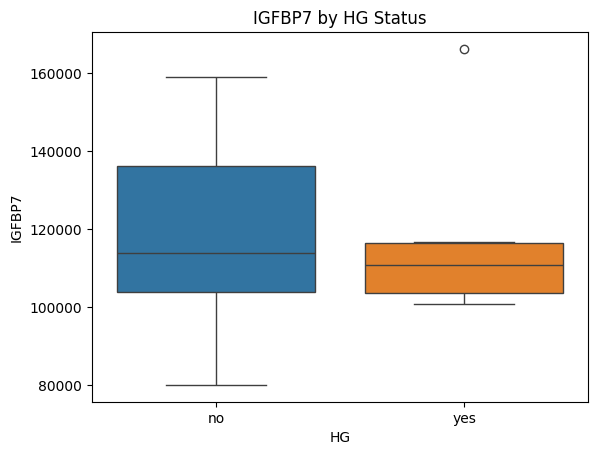

In [20]:
dist_boxplot(madres, 'IGFBP7')

#### Stat Sig - No

In [21]:
perform_statistical_tests(madres, "HG", "IGFBP7", 'yes', 'no')

Shapiro-Wilk test for yes (n=7): p-value = 0.004329627008323086
Shapiro-Wilk test for no (n=32): p-value = 0.14611655967724135
At least one group is not normally distributed. Performing Mann-Whitney U test.
Mann-Whitney U test result (n=7 vs. n=32): U-statistic = 100.0, p-value = 0.673844019973223


#### Look into IGFBP7 outlier in Madres Data

In [22]:
madres_hg[madres_hg['IGFBP7'] > 140000]

,Other Notes,HG,Clinic,ID,Date,Visit_Number,TCF7L2,GDF15,IGFBP7,EGA_Weeks,...,HELP,PUQE,Prepregnancy_Weight,Current_Weight,Weight_Change_from_Prepregnancy,PUQE_Severity,HELP_Severity,Weight_Change_from_Last_Visit,Weight_Difference_from_Prepreg (%),Weight_Difference_from_Last
10,hg,yes,madres,26_RD09972,NaT,1,996.911824,13093.175085,166242.875982,10.857,...,NaN,13.0,155.0264,NaN,NaN,High,Unknown,NaN,NaN,NaN


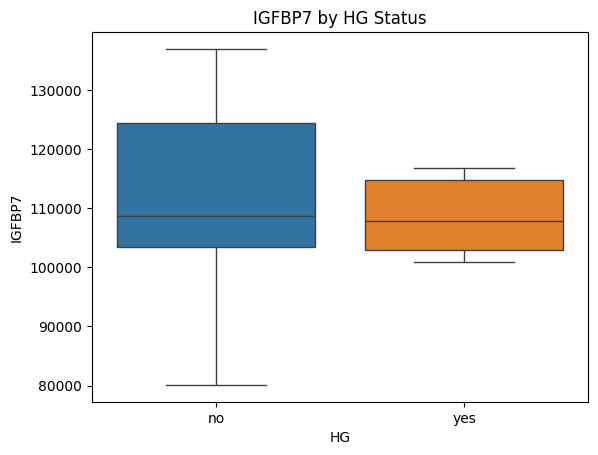

In [23]:
# boxplot with outlier removed
madres_igf_outlier_removed = madres[madres['IGFBP7'] < 140000]
dist_boxplot(madres_igf_outlier_removed, 'IGFBP7')

#### Stat Sig - No

In [24]:
perform_statistical_tests(madres_igf_outlier_removed, "HG", "IGFBP7", 'yes', 'no')

Shapiro-Wilk test for yes (n=6): p-value = 0.28966237604281575
Shapiro-Wilk test for no (n=26): p-value = 0.32788659123849156
Both groups are normally distributed. Performing t-tests.
Independent t-test result (n=6 vs. n=26): t-statistic = -0.3425735479920608, p-value = 0.7343080090095471
Welch's t-test result (n=6 vs. n=26): t-statistic = -0.5478251374766694, p-value = 0.5901083734906489


##### Remove Outliers

In [25]:
# madres df with both igf and tcf outliers removed
condition1 = madres['IGFBP7'] < 140000 
condition2 = madres['TCF7L2'] < 18000
combined_condition = condition1 & condition2
madres_tcf_igf_outliers_removed = madres[combined_condition]

### Protein Distribution by Race
*  Only for Latina patients since there is only 1 Black patient with HG and 0 White patients with HG.

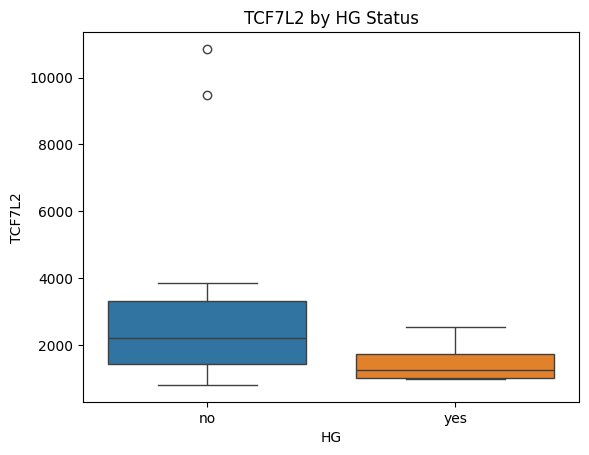

In [26]:
madres_latina = madres[madres['Race'] == 'latina']
latina_condition = madres['Race'] == 'latina'
tcf_condition = madres['TCF7L2'] < 18000 
combined = latina_condition & tcf_condition
madres_latina_tcf_outlier_removed = madres[combined]
dist_boxplot(madres_latina_tcf_outlier_removed, 'TCF7L2')

#### Stat Sig - No

In [27]:
perform_statistical_tests(madres_latina_tcf_outlier_removed, "HG", "TCF7L2", 'yes', 'no')

Shapiro-Wilk test for yes (n=5): p-value = 0.19535453246415935
Shapiro-Wilk test for no (n=17): p-value = 0.00015874665959113448
At least one group is not normally distributed. Performing Mann-Whitney U test.
Mann-Whitney U test result (n=5 vs. n=17): U-statistic = 28.0, p-value = 0.28267638793954586


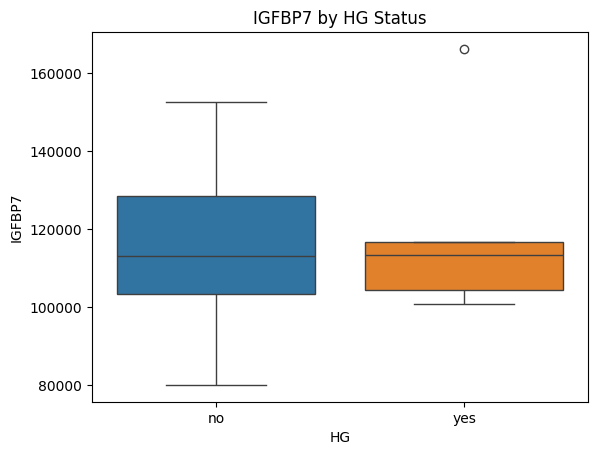

In [28]:
dist_boxplot(madres_latina, 'IGFBP7')

#### Stat Sig - No

In [29]:
perform_statistical_tests(madres_latina, "HG", "IGFBP7", 'yes', 'no')

Shapiro-Wilk test for yes (n=6): p-value = 0.016780596062316817
Shapiro-Wilk test for no (n=17): p-value = 0.8124614872451918
At least one group is not normally distributed. Performing Mann-Whitney U test.
Mann-Whitney U test result (n=6 vs. n=17): U-statistic = 50.0, p-value = 0.9720672590138447


## Protein Expression Avg Madres with HG and Madres without HG - Madres Clinic (outliers removed)

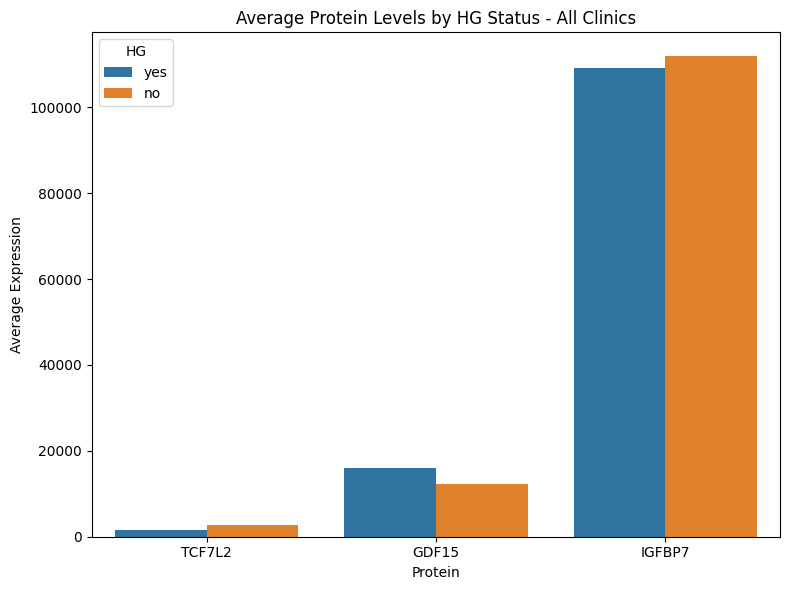

📊 Mann–Whitney U Test Results (with sample sizes):
TCF7L2: p = 0.6918 (⛔ Not significant) — n_yes = 4, n_no = 25
GDF15: p = 0.1810 (⛔ Not significant) — n_yes = 4, n_no = 25
IGFBP7: p = 0.5908 (⛔ Not significant) — n_yes = 4, n_no = 25


In [30]:
# List of proteins to analyze
proteins = ['TCF7L2', 'GDF15', 'IGFBP7']

# Initialize lists
avg_data = []
p_values = {}

for protein in proteins:
    hg_yes = madres_tcf_igf_outliers_removed[madres_tcf_igf_outliers_removed['HG'] == 'yes'][protein].dropna()
    hg_no = madres_tcf_igf_outliers_removed[madres_tcf_igf_outliers_removed['HG'] == 'no'][protein].dropna()

    # Sample sizes
    n_yes = len(hg_yes)
    n_no = len(hg_no)

    # Means for plotting
    avg_data.append({'Protein': protein, 'HG': 'yes', 'Average': hg_yes.mean(), 'N': n_yes})
    avg_data.append({'Protein': protein, 'HG': 'no', 'Average': hg_no.mean(), 'N': n_no})

    # Mann–Whitney U test (non-parametric)
    u_stat, p_val = mannwhitneyu(hg_yes, hg_no, alternative='two-sided')
    p_values[protein] = (p_val, n_yes, n_no)

# Convert to DataFrame for seaborn plotting
avg_df = pd.DataFrame(avg_data)

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(data=avg_df, x='Protein', y='Average', hue='HG')
plt.title('Average Protein Levels by HG Status - All Clinics')
plt.ylabel('Average Expression')
plt.tight_layout()
plt.show()

# Print p-values and sample sizes
print("📊 Mann–Whitney U Test Results (with sample sizes):")
for protein, (p_val, n_yes, n_no) in p_values.items():
    sig = "✳️ Significant" if p_val < 0.05 else "⛔ Not significant"
    print(f"{protein}: p = {p_val:.4f} ({sig}) — n_yes = {n_yes}, n_no = {n_no}")

## Protein Expression Median Madres with HG and Madres without HG - Madres Clinic (outliers removed)

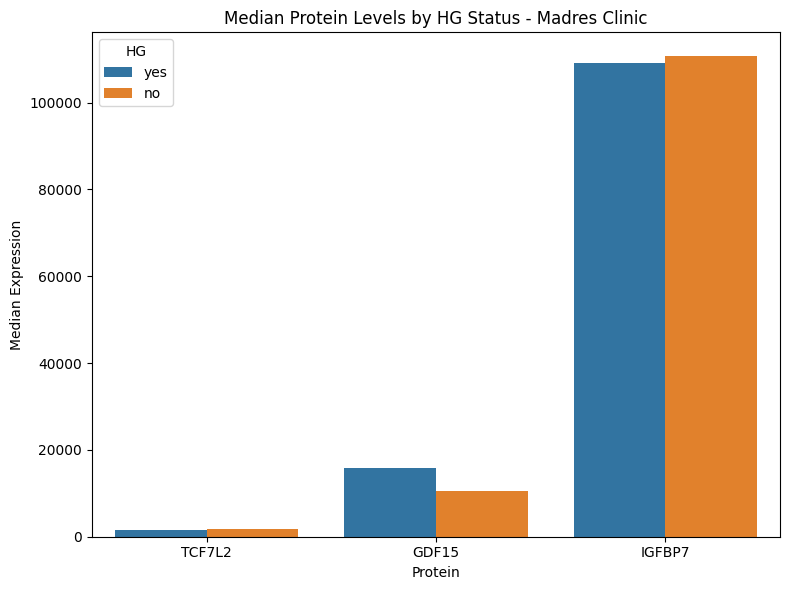

📊 Mann–Whitney U Test Results (with sample sizes):
TCF7L2: p = 0.6918 (⛔ Not significant) — n_yes = 4, n_no = 25
GDF15: p = 0.1810 (⛔ Not significant) — n_yes = 4, n_no = 25
IGFBP7: p = 0.5908 (⛔ Not significant) — n_yes = 4, n_no = 25


In [31]:
# List of proteins to analyze
proteins = ['TCF7L2', 'GDF15', 'IGFBP7']

# Initialize lists
median_data = []
p_values = {}

for protein in proteins:
    hg_yes = madres_tcf_igf_outliers_removed[madres_tcf_igf_outliers_removed['HG'] == 'yes'][protein].dropna()
    hg_no = madres_tcf_igf_outliers_removed[madres_tcf_igf_outliers_removed['HG'] == 'no'][protein].dropna()

    # Sample sizes
    n_yes = len(hg_yes)
    n_no = len(hg_no)

    # Means for plotting
    median_data.append({'Protein': protein, 'HG': 'yes', 'Median': hg_yes.median(), 'N': n_yes})
    median_data.append({'Protein': protein, 'HG': 'no', 'Median': hg_no.median(), 'N': n_no})

    # Mann–Whitney U test (non-parametric)
    u_stat, p_val = mannwhitneyu(hg_yes, hg_no, alternative='two-sided')
    p_values[protein] = (p_val, n_yes, n_no)

# Convert to DataFrame for seaborn plotting
median_df = pd.DataFrame(median_data)

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(data=median_df, x='Protein', y='Median', hue='HG')
plt.title('Median Protein Levels by HG Status - Madres Clinic')
plt.ylabel('Median Expression')
plt.tight_layout()
plt.show()

# Print p-values and sample sizes
print("📊 Mann–Whitney U Test Results (with sample sizes):")
for protein, (p_val, n_yes, n_no) in p_values.items():
    sig = "✳️ Significant" if p_val < 0.05 else "⛔ Not significant"
    print(f"{protein}: p = {p_val:.4f} ({sig}) — n_yes = {n_yes}, n_no = {n_no}")

# All Clinics Data

## Protein Expression Median Madres without HG and all Patients with HG - All Clinics
* Only references first visit to ensure independence

In [32]:
first_visits = cleaned_visits[cleaned_visits['Visit_Number'] == 1]

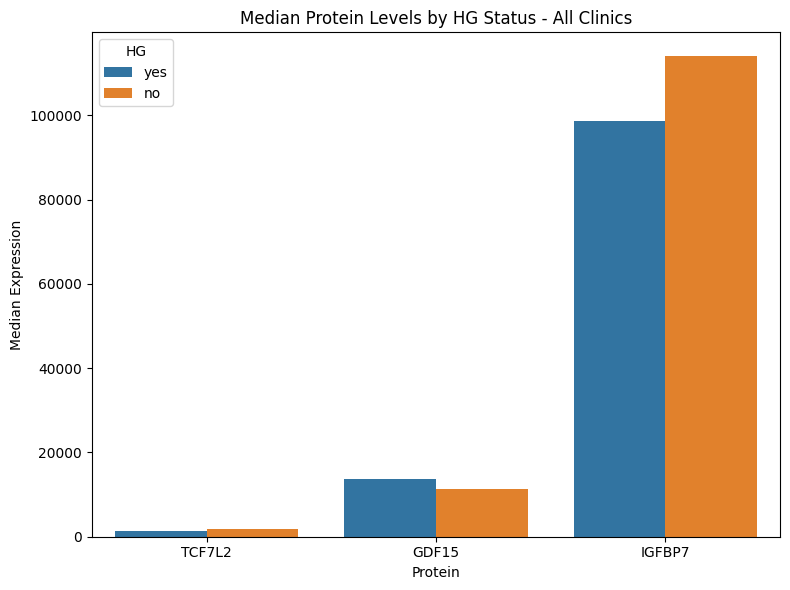

📊 Mann–Whitney U Test Results (with sample sizes):
TCF7L2: p = 0.3897 (⛔ Not significant) — n_yes = 106, n_no = 32
GDF15: p = 0.0277 (✳️ Significant) — n_yes = 106, n_no = 32
IGFBP7: p = 0.0000 (✳️ Significant) — n_yes = 106, n_no = 32


In [33]:
# List of proteins to analyze
proteins = ['TCF7L2', 'GDF15', 'IGFBP7']

# Initialize lists
median_data = []
p_values = {}

for protein in proteins:
    hg_yes = first_visits[first_visits['HG'] == 'yes'][protein].dropna()
    hg_no = first_visits[first_visits['HG'] == 'no'][protein].dropna()

    # Sample sizes
    n_yes = len(hg_yes)
    n_no = len(hg_no)

    # Means for plotting
    median_data.append({'Protein': protein, 'HG': 'yes', 'Median': hg_yes.median(), 'N': n_yes})
    median_data.append({'Protein': protein, 'HG': 'no', 'Median': hg_no.median(), 'N': n_no})

    # Mann–Whitney U test (non-parametric)
    u_stat, p_val = mannwhitneyu(hg_yes, hg_no, alternative='two-sided')
    p_values[protein] = (p_val, n_yes, n_no)

# Convert to DataFrame for seaborn plotting
median_df = pd.DataFrame(median_data)

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(data=median_df, x='Protein', y='Median', hue='HG')
plt.title('Median Protein Levels by HG Status - All Clinics')
plt.ylabel('Median Expression')
plt.tight_layout()
plt.show()

# Print p-values and sample sizes
print("📊 Mann–Whitney U Test Results (with sample sizes):")
for protein, (p_val, n_yes, n_no) in p_values.items():
    sig = "✳️ Significant" if p_val < 0.05 else "⛔ Not significant"
    print(f"{protein}: p = {p_val:.4f} ({sig}) — n_yes = {n_yes}, n_no = {n_no}")

## Protein Expression Avg Madres without HG and all Patients with HG - All Clinics
* Only references first visit to ensure independence

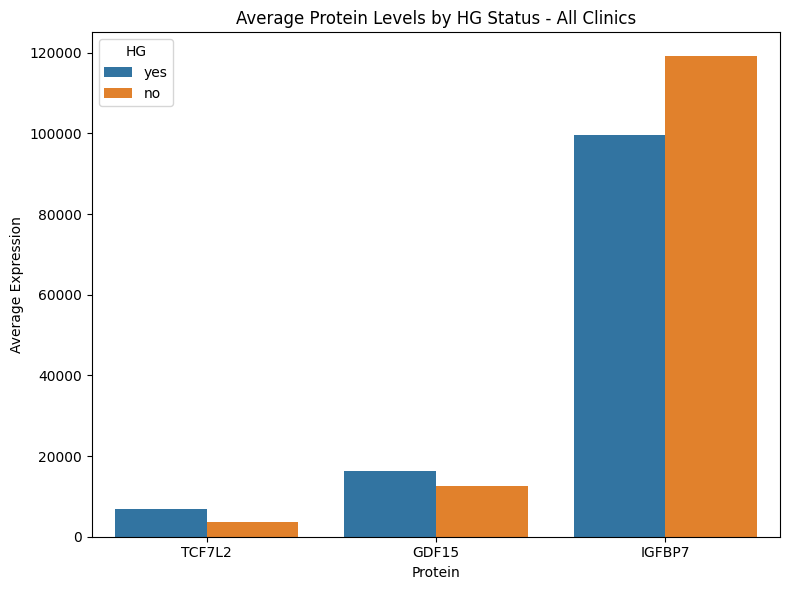

📊 Mann–Whitney U Test Results (with sample sizes):
TCF7L2: p = 0.3897 (⛔ Not significant) — n_yes = 106, n_no = 32
GDF15: p = 0.0277 (✳️ Significant) — n_yes = 106, n_no = 32
IGFBP7: p = 0.0000 (✳️ Significant) — n_yes = 106, n_no = 32


In [34]:
# List of proteins to analyze
proteins = ['TCF7L2', 'GDF15', 'IGFBP7']

# Initialize lists
avg_data = []
p_values = {}

for protein in proteins:
    hg_yes = first_visits[first_visits['HG'] == 'yes'][protein].dropna()
    hg_no = first_visits[first_visits['HG'] == 'no'][protein].dropna()

    # Sample sizes
    n_yes = len(hg_yes)
    n_no = len(hg_no)

    # Means for plotting
    avg_data.append({'Protein': protein, 'HG': 'yes', 'Average': hg_yes.mean(), 'N': n_yes})
    avg_data.append({'Protein': protein, 'HG': 'no', 'Average': hg_no.mean(), 'N': n_no})

    # Mann–Whitney U test (non-parametric)
    u_stat, p_val = mannwhitneyu(hg_yes, hg_no, alternative='two-sided')
    p_values[protein] = (p_val, n_yes, n_no)

# Convert to DataFrame for seaborn plotting
avg_df = pd.DataFrame(avg_data)

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(data=avg_df, x='Protein', y='Average', hue='HG')
plt.title('Average Protein Levels by HG Status - All Clinics')
plt.ylabel('Average Expression')
plt.tight_layout()
plt.show()

# Print p-values and sample sizes
print("📊 Mann–Whitney U Test Results (with sample sizes):")
for protein, (p_val, n_yes, n_no) in p_values.items():
    sig = "✳️ Significant" if p_val < 0.05 else "⛔ Not significant"
    print(f"{protein}: p = {p_val:.4f} ({sig}) — n_yes = {n_yes}, n_no = {n_no}")

## Boxplot Distributions - All Clinics
* Only first visits to ensure independence.

In [35]:
first_visits = cleaned_visits[cleaned_visits['Visit_Number'] == 1]

### PUQE by HG Status

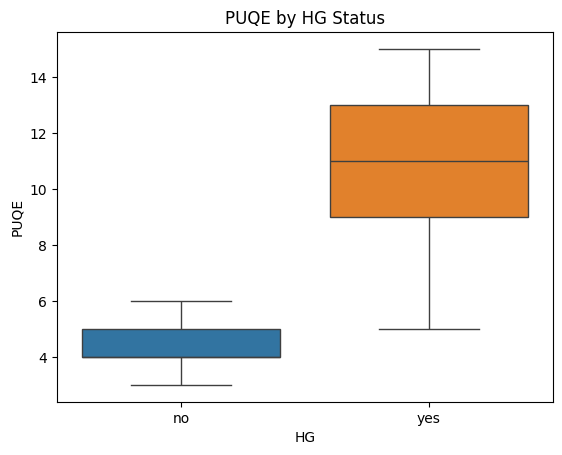

In [36]:
dist_boxplot(first_visits, 'PUQE')

#### Stat Sig - Yes (to be expected)

In [37]:
perform_statistical_tests(first_visits, "HG", "PUQE", 'yes', 'no')

Shapiro-Wilk test for yes (n=105): p-value = 7.191087344790055e-05
Shapiro-Wilk test for no (n=32): p-value = 0.0014658277589733213
At least one group is not normally distributed. Performing Mann-Whitney U test.
Mann-Whitney U test result (n=105 vs. n=32): U-statistic = 3350.0, p-value = 1.3685282086070816e-17


### EGA by HG Status (All Clinics)

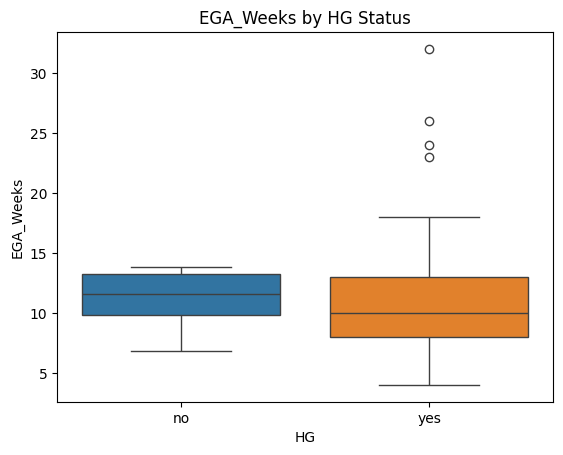

In [38]:
dist_boxplot(first_visits, 'EGA_Weeks')

#### Stat Sig - No

In [39]:
perform_statistical_tests(first_visits, "HG", "EGA_Weeks", 'yes', 'no')

Shapiro-Wilk test for yes (n=101): p-value = 2.1730033369014214e-09
Shapiro-Wilk test for no (n=32): p-value = 0.018058365872542892
At least one group is not normally distributed. Performing Mann-Whitney U test.
Mann-Whitney U test result (n=101 vs. n=32): U-statistic = 1286.0, p-value = 0.08224216680641369


In [40]:
# Find EGA outliers
ega_outliers = first_visits[first_visits['EGA_Weeks'] > 20][['ID']]
ega_outliers

,ID
53,F2
89,G27
138,H23
148,H32


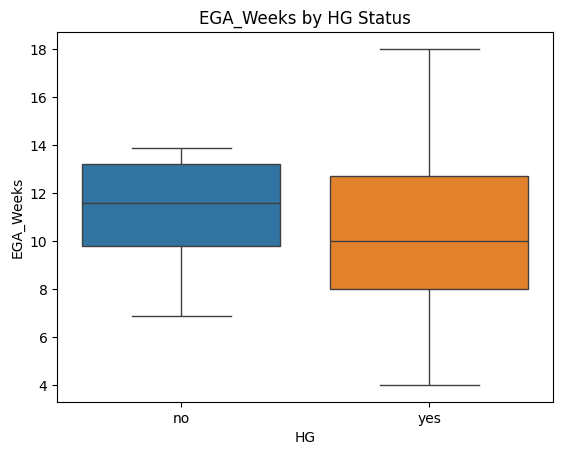

In [41]:
# Remove EGA outliers
first_visits_ega_outliers_removed = first_visits[first_visits['EGA_Weeks'] < 20]
dist_boxplot(first_visits_ega_outliers_removed, 'EGA_Weeks')

#### Stat Sig - Yes (when outliers removed)

In [42]:
perform_statistical_tests(first_visits_ega_outliers_removed, "HG", "EGA_Weeks", 'yes', 'no')

Shapiro-Wilk test for yes (n=97): p-value = 0.006488583761728072
Shapiro-Wilk test for no (n=32): p-value = 0.018058365872542892
At least one group is not normally distributed. Performing Mann-Whitney U test.
Mann-Whitney U test result (n=97 vs. n=32): U-statistic = 1158.0, p-value = 0.03151873902522457


### Insights
* When EGA_Weeks outliers are removed, there is a statistically significant difference in the average EGA between groups with and without HG.
    * This indicates that patients with HG, came in earlier, on average, for their first patient.

### Prepregnancy Weight by HG Status (All Clinics)

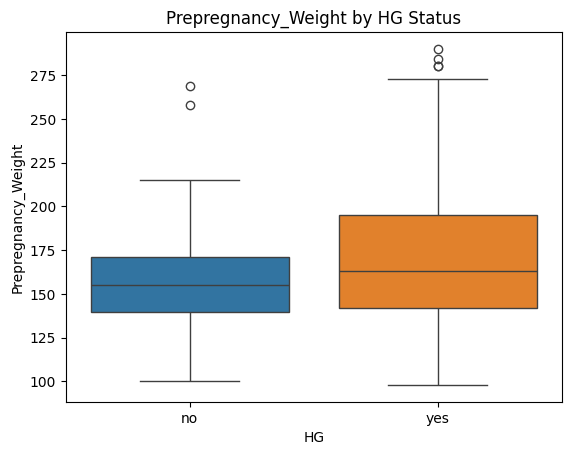

In [43]:
dist_boxplot(first_visits, 'Prepregnancy_Weight')

#### Stat Sig - No

In [44]:
perform_statistical_tests(first_visits, "HG", "Prepregnancy_Weight", 'yes', 'no')

Shapiro-Wilk test for yes (n=105): p-value = 8.660665184512454e-05
Shapiro-Wilk test for no (n=32): p-value = 0.002839808874140585
At least one group is not normally distributed. Performing Mann-Whitney U test.
Mann-Whitney U test result (n=105 vs. n=32): U-statistic = 1888.0, p-value = 0.29111479221203473


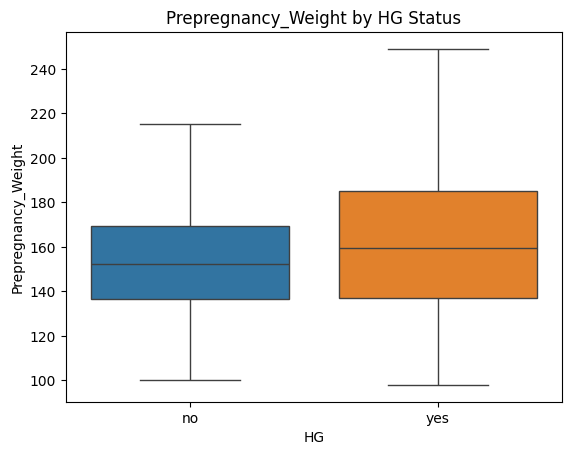

In [45]:
# remove Prepreg weight outliers
first_visits_prepreg_weight_outliers_removed = first_visits[first_visits['Prepregnancy_Weight'] < 250]
dist_boxplot(first_visits_prepreg_weight_outliers_removed, 'Prepregnancy_Weight')

#### Stat Sig - No

In [46]:
perform_statistical_tests(first_visits_prepreg_weight_outliers_removed, "HG", "Prepregnancy_Weight", 'yes', 'no')

Shapiro-Wilk test for yes (n=96): p-value = 0.02752294516799566
Shapiro-Wilk test for no (n=30): p-value = 0.8769001559151671
At least one group is not normally distributed. Performing Mann-Whitney U test.
Mann-Whitney U test result (n=96 vs. n=30): U-statistic = 1604.0, p-value = 0.3489675016930387


### TCF7L2 by HG Status (All Clinics)

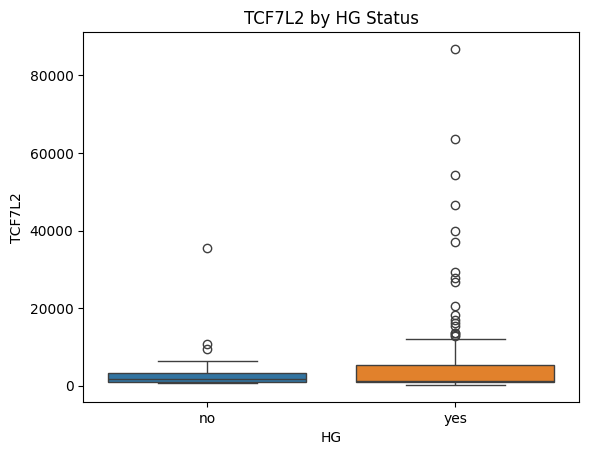

In [47]:
dist_boxplot(first_visits, 'TCF7L2')

##### Stat Sig - No

In [48]:
perform_statistical_tests(first_visits, "HG", "TCF7L2", 'yes', 'no')

Shapiro-Wilk test for yes (n=106): p-value = 4.5044163374144926e-17
Shapiro-Wilk test for no (n=32): p-value = 4.5283650383462794e-10
At least one group is not normally distributed. Performing Mann-Whitney U test.
Mann-Whitney U test result (n=106 vs. n=32): U-statistic = 1525.0, p-value = 0.38970036852807977


In [49]:
# find TCF7L2 outliers
tcf_outliers = first_visits[first_visits['TCF7L2'] > 15250][['ID']]
tcf_outliers

,ID
2,154_IN05817
4,186_CE07588
8,234_IL00110
42,F12
51,F17
60,F38
63,F40
72,G1
117,GR20
136,H22


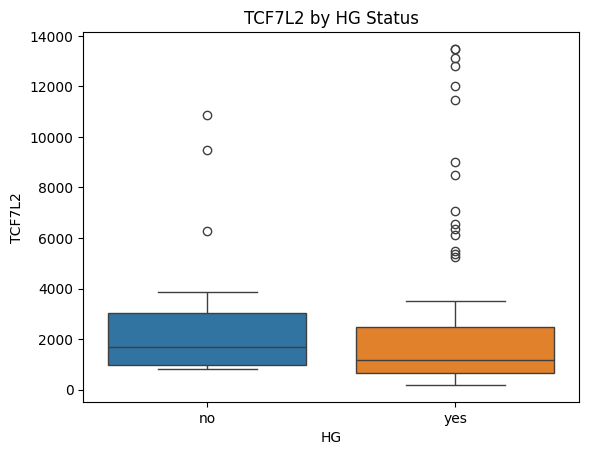

In [50]:
# remove TCF7L2 outliers 
first_visits_tcf_outliers_removed = first_visits[first_visits['TCF7L2'] < 15250]
dist_boxplot(first_visits_tcf_outliers_removed, 'TCF7L2')

##### Stat Sig - Yes (when outliers > 15250 removed)

In [51]:
perform_statistical_tests(first_visits_tcf_outliers_removed, "HG", "TCF7L2", 'yes', 'no')

Shapiro-Wilk test for yes (n=92): p-value = 1.390333642360313e-13
Shapiro-Wilk test for no (n=31): p-value = 1.0342060195722823e-06
At least one group is not normally distributed. Performing Mann-Whitney U test.
Mann-Whitney U test result (n=92 vs. n=31): U-statistic = 1085.0, p-value = 0.04731673875484408


### Insights
* These results are consistent with hypothesis that TCF7L2 may serve as a protective feature of HG **when the outliers are removed**. Otherwise, the outliers skew the TCf7L2 distribution and increase the mean.
    * n=92 for patients with HG and n=31 when outliers are removed (all clinic data).

### GDF15 by HG Status (All Clinics)

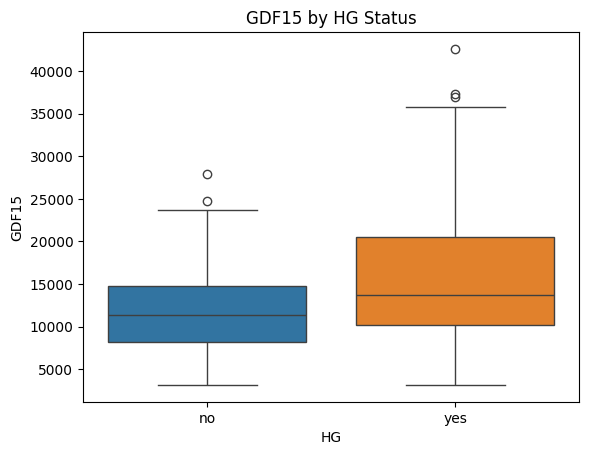

In [52]:
dist_boxplot(first_visits, 'GDF15')

##### Stat Sig - Yes (consistent with previous research)

In [53]:
perform_statistical_tests(first_visits, "HG", "GDF15", 'yes', 'no')

Shapiro-Wilk test for yes (n=106): p-value = 2.335910456091539e-06
Shapiro-Wilk test for no (n=32): p-value = 0.016047639051325523
At least one group is not normally distributed. Performing Mann-Whitney U test.
Mann-Whitney U test result (n=106 vs. n=32): U-statistic = 2133.0, p-value = 0.027657345895839854


In [54]:
# Find GDF15 outliers
gdf_outliers = first_visits[first_visits['GDF15'] > 40000][['ID']]
gdf_outliers

,ID
89,G27


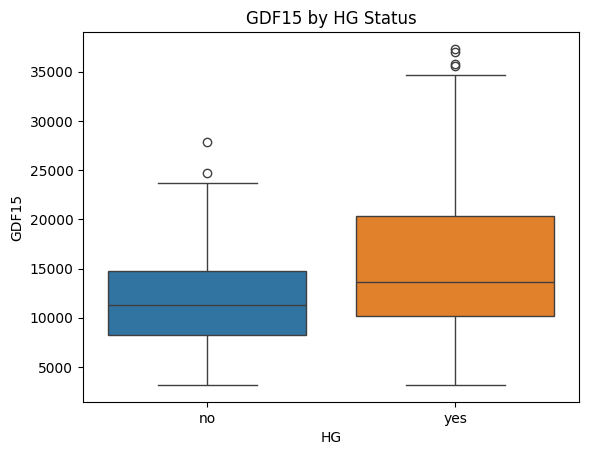

In [55]:
# remove GDF15 outliers 
first_visits_gdf_outliers_removed = first_visits[first_visits['GDF15'] < 40000]
dist_boxplot(first_visits_gdf_outliers_removed, 'GDF15')

##### Stat Sig - Yes (consistent with previous research)

In [56]:
perform_statistical_tests(first_visits_gdf_outliers_removed, "HG", "GDF15", 'yes', 'no')

Shapiro-Wilk test for yes (n=105): p-value = 4.6969376737228635e-06
Shapiro-Wilk test for no (n=32): p-value = 0.016047639051325523
At least one group is not normally distributed. Performing Mann-Whitney U test.
Mann-Whitney U test result (n=105 vs. n=32): U-statistic = 2101.0, p-value = 0.03242104875792999


### Insights
* These results are consistent with previous research that indicates higher levels of GDF15 for patients with HG. 
    * Even when outliers are removed.

### IGFBP7 by HG Status (All Clinics)

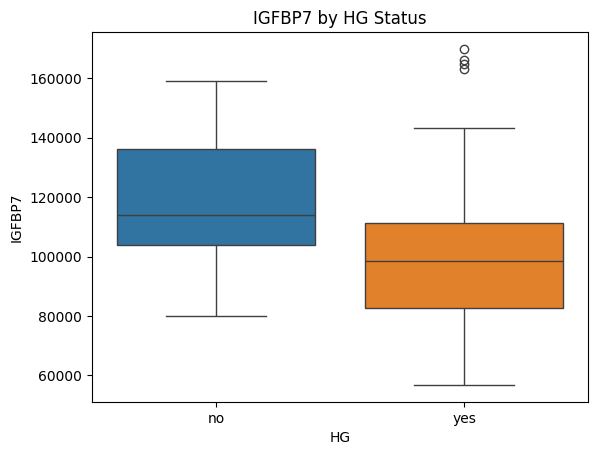

In [204]:
dist_boxplot(first_visits, 'IGFBP7')

#### Stat Sig - Yes

In [205]:
perform_statistical_tests(first_visits, "HG", "IGFBP7", 'yes', 'no')

Shapiro-Wilk test for yes (n=106): p-value = 0.0007302866382344739
Shapiro-Wilk test for no (n=32): p-value = 0.14611655967724135
At least one group is not normally distributed. Performing Mann-Whitney U test.
Mann-Whitney U test result (n=106 vs. n=32): U-statistic = 878.0, p-value = 3.719589904630438e-05


In [59]:
# Find IGFBP7 outliers
igf_outliers = first_visits[first_visits['IGFBP7'] > 160000][['ID']]
igf_outliers

,ID
10,26_RD09972
118,H1
128,H13
154,H36


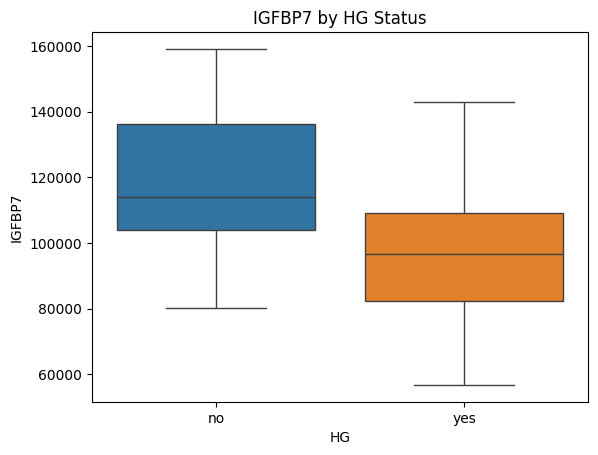

In [60]:
# remove IGFBP7 outliers 
first_visits_igf_outliers_removed = first_visits[first_visits['IGFBP7'] < 160000]
dist_boxplot(first_visits_igf_outliers_removed, 'IGFBP7')

#### Stat Sig - Yes

In [61]:
perform_statistical_tests(first_visits_igf_outliers_removed, "HG", "IGFBP7", 'yes', 'no')

Shapiro-Wilk test for yes (n=102): p-value = 0.6442790830425523
Shapiro-Wilk test for no (n=32): p-value = 0.14611655967724135
Both groups are normally distributed. Performing t-tests.
Independent t-test result (n=102 vs. n=32): t-statistic = -5.571292524024453, p-value = 1.3638438120220002e-07
Welch's t-test result (n=102 vs. n=32): t-statistic = -5.048516552724184, p-value = 7.77711018045512e-06


### Insights
* These results are inconsistent with previous research that indicates a higher level of IGFBP7 present in patients with HG.

### Outliers

In [62]:
# Return outlier Patient IDs for comparison
# ega_outliers, tcf_outliers, gdf_outliers, igf_outliers

# Dictionary mapping names to their respective outlier DataFrames
outlier_dfs = {
    'EGA Outliers': ega_outliers,
    'TCF Outliers': tcf_outliers,
    'GDF Outliers': gdf_outliers,
    'IGF Outliers': igf_outliers
}

# Print each list of outliers under a section title
for title, df in outlier_dfs.items():
    print(f"\n📌 {title}")
    print(df.iloc[:, 0].tolist())  # Assumes the patient IDs are in the only column


📌 EGA Outliers
['F2', 'G27', 'H23', 'H32']

📌 TCF Outliers
['154_IN05817', '186_CE07588', '234_IL00110', 'F12', 'F17', 'F38', 'F40', 'G1', 'GR20', 'H22', 'H26', 'H36', 'H8', 'I36', 'K18']

📌 GDF Outliers
['G27']

📌 IGF Outliers
['26_RD09972', 'H1', 'H13', 'H36']


## Race Boxplots

### Latina

### Lowest Quartile TCF7L2 vs. Rest (All Data)
* Comparing median GA, HELP, PUQE, prepregnancy weight, and current between top quartile and rest of TCF7L2 levels.
* Will drop any rows with missing values.

In [93]:
second_visits = cleaned_visits[cleaned_visits['Visit_Number'] == 2]

In [119]:
# Filter the data for patients with HG 
first_visits_hg = first_visits[first_visits['HG'] == 'yes']
second_visits_hg = second_visits[second_visits['HG'] == 'yes']

# Remove madres TCF7L2 extreme outlier
first_visits_hg_tcf_outlier_removed = first_visits_hg[first_visits_hg['TCF7L2'] < 15250]

# Calculate the 25th percentile (lowest quartile) of TCF7L2 for both first and second visits
lowest_quartile_threshold_first = first_visits_hg_tcf_outlier_removed['TCF7L2'].quantile(0.25)
lowest_quartile_threshold_second = second_visits_hg['TCF7L2'].quantile(0.25)

# Split the data into High and Low TCF7L2 groups based on the lowest quartile threshold
first_visits_hg_tcf_outlier_removed['TCF_Group'] = ['Low' if x <= lowest_quartile_threshold_first else 'High' for x in first_visits_hg_tcf_outlier_removed['TCF7L2']]
second_visits_hg['TCF_Group'] = ['Low' if x <= lowest_quartile_threshold_second else 'High' for x in second_visits_hg['TCF7L2']]


# Define the metrics we want to analyze
metrics_to_analyze = [
    "EGA_Weeks", "HELP", "PUQE", "Prepregnancy_Weight", "Current_Weight", 
    "Weight_Change_from_Prepregnancy", "Weight_Change_from_Last_Visit", 
    "TCF7L2"
]

# Initialize an empty list to store the summary data
summary_data = []

# Function to calculate median, sample size, and perform normality check
def calculate_summary(data, metric):
    high_values = data[data['TCF_Group'] == 'High'][metric].dropna()
    low_values = data[data['TCF_Group'] == 'Low'][metric].dropna()
    
    # Sample sizes
    sample_size_high = len(high_values)
    sample_size_low = len(low_values)
    
    # Skip normality test if either group has fewer than 3 values
    if sample_size_high < 3 or sample_size_low < 3:
        test_used = "Not enough data for normality test"
        p_value = None
        significant = "Insufficient data"
        median_high = high_values.median() if sample_size_high > 0 else "N/A"
        median_low = low_values.median() if sample_size_low > 0 else "N/A"
        return median_high, median_low, significant, test_used, sample_size_high, sample_size_low, p_value
    
    # Check normality
    normal_high = shapiro(high_values)[1] >= 0.05
    normal_low = shapiro(low_values)[1] >= 0.05
    
    # Determine which test to use
    if normal_high and normal_low:
        # Use t-test if both groups are normal
        t_stat, p_value = ttest_ind(high_values, low_values, nan_policy='omit')
        test_used = "t-test"
    else:
        # Use Mann-Whitney U test if not normal
        t_stat, p_value = mannwhitneyu(high_values, low_values, alternative='two-sided')
        test_used = "Mann-Whitney U"

    # Calculate medians
    median_high = high_values.median()
    median_low = low_values.median()
    
    # Check if the difference is significant
    significant = "Yes" if p_value < 0.05 else "No"
    
    return median_high, median_low, significant, test_used, sample_size_high, sample_size_low, p_value

# Perform the analysis for each metric
for metric in metrics_to_analyze:
    # For first visit
    median_high_first, median_low_first, significant_first, test_used_first, sample_size_high_first, sample_size_low_first, p_value_first = calculate_summary(first_visits_hg_tcf_outlier_removed, metric)
    
    # For second visit
    median_high_second, median_low_second, significant_second, test_used_second, sample_size_high_second, sample_size_low_second, p_value_second = calculate_summary(second_visits_hg, metric)

    # Add the results to the summary data list
    summary_data.append({
        "Metric": f"{metric} - 1st Visit High vs Low TCF7L2", 
        "Median (High)": median_high_first, 
        "Median (Low)": median_low_first,
        "Significant Difference (p < 0.05)": significant_first,
        "Test Used": test_used_first,
        "Sample Size (High)": sample_size_high_first,
        "Sample Size (Low)": sample_size_low_first,
        "p-value": p_value_first 
    })
    
    summary_data.append({
        "Metric": f"{metric} - 2nd Visit High vs Low TCF7L2", 
        "Median (High)": median_high_second, 
        "Median (Low)": median_low_second,
        "Significant Difference (p < 0.05)": significant_second,
        "Test Used": test_used_second,
        "Sample Size (High)": sample_size_high_second,
        "Sample Size (Low)": sample_size_low_second,
        "p-value": p_value_second 
    })

# Convert the list of dictionaries into a DataFrame
summary_table = pd.DataFrame(summary_data)

# Display the updated summary table
summary_table
# Export the table if needed
# summary_table.to_excel('tcf_high_low_quartile_table.xlsx', index=False)


/var/folders/nq/fg50vmnx4gzffp_j9phbgljh0000gn/T/ipykernel_45636/646386818.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_visits_hg_tcf_outlier_removed['TCF_Group'] = ['Low' if x <= lowest_quartile_threshold_first else 'High' for x in first_visits_hg_tcf_outlier_removed['TCF7L2']]


,Metric,Median (High),Median (Low),Significant Difference (p < 0.05),Test Used,Sample Size (High),Sample Size (Low),p-value
0,EGA_Weeks - 1st Visit High vs Low TCF7L2,10.0,9.5,No,Mann-Whitney U,67,22,6.126363e-01
1,EGA_Weeks - 2nd Visit High vs Low TCF7L2,12.05,13.3,No,Mann-Whitney U,60,21,4.439863e-01
2,HELP - 1st Visit High vs Low TCF7L2,33.0,36.0,No,Mann-Whitney U,62,23,6.627372e-01
3,HELP - 2nd Visit High vs Low TCF7L2,25.0,23.0,No,t-test,60,21,5.086312e-01
4,PUQE - 1st Visit High vs Low TCF7L2,11.0,12.5,No,Mann-Whitney U,69,22,1.027842e-01
5,PUQE - 2nd Visit High vs Low TCF7L2,9.0,8.5,No,Mann-Whitney U,60,20,8.668789e-01
6,Prepregnancy_Weight - 1st Visit High vs Low TC...,161.0,160.0,No,Mann-Whitney U,69,22,2.353302e-01
7,Prepregnancy_Weight - 2nd Visit High vs Low TC...,164.0,160.0,No,Mann-Whitney U,60,21,4.095565e-01
8,Current_Weight - 1st Visit High vs Low TCF7L2,160.0,152.0,No,Mann-Whitney U,61,23,1.298053e-01
9,Current_Weight - 2nd Visit High vs Low TCF7L2,168.0,159.0,No,Mann-Whitney U,60,21,4.603243e-01


### Lowest Quartile TCF7L2 vs. Rest (MSC Only)
* Comparing median GA, HELP, PUQE, prepregnancy weight, and current between top quartile and rest of TCF7L2 levels.
* Will drop any rows with missing values.

In [77]:
msc_only_first_visits = first_visits[first_visits['Clinic'] == "msc"]
msc_only_second_visits = second_visits[second_visits['Clinic'] == "msc"]

# Filter the data for patients with HG 
msc_first_visits_hg = msc_only_first_visits[msc_only_first_visits['HG'] == 'yes']
msc_second_visits_hg = second_visits[second_visits['HG'] == 'yes']

# Calculate the 25th percentile (lowest quartile) of TCF7L2 for both first and second visits
lowest_quartile_threshold_first = msc_first_visits_hg['TCF7L2'].quantile(0.25)
lowest_quartile_threshold_second = msc_second_visits_hg['TCF7L2'].quantile(0.25)

# Split the data into High and Low TCF7L2 groups based on the lowest quartile threshold
msc_first_visits_hg['TCF_Group'] = ['Low' if x <= lowest_quartile_threshold_first else 'High' for x in msc_first_visits_hg['TCF7L2']]
msc_second_visits_hg['TCF_Group'] = ['Low' if x <= lowest_quartile_threshold_second else 'High' for x in msc_second_visits_hg['TCF7L2']]


# Define the metrics we want to analyze
metrics_to_analyze = [
    "EGA_Weeks", "HELP", "PUQE", "Prepregnancy_Weight", "Current_Weight", 
    "Weight_Change_from_Prepregnancy", "Weight_Change_from_Last_Visit", 
    "TCF7L2"
]

# Initialize an empty list to store the summary data
summary_data = []

# Function to calculate median, sample size, and perform normality check
def calculate_summary(data, metric):
    high_values = data[data['TCF_Group'] == 'High'][metric].dropna()
    low_values = data[data['TCF_Group'] == 'Low'][metric].dropna()
    
    # Sample sizes
    sample_size_high = len(high_values)
    sample_size_low = len(low_values)
    
    # Skip normality test if either group has fewer than 3 values
    if sample_size_high < 3 or sample_size_low < 3:
        test_used = "Not enough data for normality test"
        p_value = None
        significant = "Insufficient data"
        median_high = high_values.median() if sample_size_high > 0 else "N/A"
        median_low = low_values.median() if sample_size_low > 0 else "N/A"
        return median_high, median_low, significant, test_used, sample_size_high, sample_size_low, p_value
    
    # Check normality
    normal_high = shapiro(high_values)[1] >= 0.05
    normal_low = shapiro(low_values)[1] >= 0.05
    
    # Determine which test to use
    if normal_high and normal_low:
        # Use t-test if both groups are normal
        t_stat, p_value = ttest_ind(high_values, low_values, nan_policy='omit')
        test_used = "t-test"
    else:
        # Use Mann-Whitney U test if not normal
        t_stat, p_value = mannwhitneyu(high_values, low_values, alternative='two-sided')
        test_used = "Mann-Whitney U"

    # Calculate medians
    median_high = high_values.median()
    median_low = low_values.median()
    
    # Check if the difference is significant
    significant = "Yes" if p_value < 0.05 else "No"
    
    return median_high, median_low, significant, test_used, sample_size_high, sample_size_low, p_value

# Perform the analysis for each metric
for metric in metrics_to_analyze:
    # For first visit
    median_high_first, median_low_first, significant_first, test_used_first, sample_size_high_first, sample_size_low_first, p_value_first = calculate_summary(msc_first_visits_hg, metric)
    
    # For second visit
    median_high_second, median_low_second, significant_second, test_used_second, sample_size_high_second, sample_size_low_second, p_value_second = calculate_summary(msc_second_visits_hg, metric)

    # Add the results to the summary data list
    summary_data.append({
        "Metric": f"{metric} - 1st Visit High vs Low TCF7L2", 
        "Median (High)": median_high_first, 
        "Median (Low)": median_low_first,
        "Significant Difference (p < 0.05)": significant_first,
        "Test Used": test_used_first,
        "Sample Size (High)": sample_size_high_first,
        "Sample Size (Low)": sample_size_low_first,
        "p-value": p_value_first 
    })
    
    summary_data.append({
        "Metric": f"{metric} - 2nd Visit High vs Low TCF7L2", 
        "Median (High)": median_high_second, 
        "Median (Low)": median_low_second,
        "Significant Difference (p < 0.05)": significant_second,
        "Test Used": test_used_second,
        "Sample Size (High)": sample_size_high_second,
        "Sample Size (Low)": sample_size_low_second,
        "p-value": p_value_second 
    })

# Convert the list of dictionaries into a DataFrame
summary_table = pd.DataFrame(summary_data)

# Display the updated summary table
summary_table
# Export the table if needed
# summary_table.to_excel('tcf_high_low_quartile_table_msc_only_june25.xlsx', index=False)


,Metric,Median (High),Median (Low),Significant Difference (p < 0.05),Test Used,Sample Size (High),Sample Size (Low),p-value
0,EGA_Weeks - 1st Visit High vs Low TCF7L2,10.0,9.5,No,Mann-Whitney U,70,24,6.193631e-01
1,EGA_Weeks - 2nd Visit High vs Low TCF7L2,12.05,13.3,No,Mann-Whitney U,60,21,4.439863e-01
2,HELP - 1st Visit High vs Low TCF7L2,32.0,36.0,No,Mann-Whitney U,70,25,4.639134e-01
3,HELP - 2nd Visit High vs Low TCF7L2,25.0,23.0,No,t-test,60,21,5.086312e-01
4,PUQE - 1st Visit High vs Low TCF7L2,11.0,12.0,Yes,Mann-Whitney U,74,24,3.601704e-02
5,PUQE - 2nd Visit High vs Low TCF7L2,9.0,8.5,No,Mann-Whitney U,60,20,8.668789e-01
6,Prepregnancy_Weight - 1st Visit High vs Low TC...,163.5,166.5,No,Mann-Whitney U,74,24,3.970267e-01
7,Prepregnancy_Weight - 2nd Visit High vs Low TC...,164.0,160.0,No,Mann-Whitney U,60,21,4.095565e-01
8,Current_Weight - 1st Visit High vs Low TCF7L2,160.0,152.0,No,Mann-Whitney U,69,25,2.550161e-01
9,Current_Weight - 2nd Visit High vs Low TCF7L2,168.0,159.0,No,Mann-Whitney U,60,21,4.603243e-01


### Explore why Current Weight is no longer Statistically Significant
* Current weight difference between high and low levels of TCF7L2 is no longer significant when introducing new data (n=17).
* Look if distributions are drastically different between datasets.

In [176]:
# Separate msc data from madres data
msc_data = cleaned_visits[cleaned_visits['Clinic'] == 'msc']

# Add a column to msc_data that signifies if data is old or new
msc_data['Old_New'] = msc_data['Other Notes'].apply(lambda x: 'old data' if x == 'old data' else 'new data')

# Do the same for msc_data_first_visit that was already created above
msc_data_first_visit = msc_data[msc_data['Visit_Number'] == 1]
msc_data_first_visit['Old_New'] = msc_data_first_visit['Other Notes'].apply(lambda x: 'old data' if x == 'old data' else 'new data')

# Do the same for msc_first_visits_hg which was created above and contains TCF7L2 group column
msc_first_visits_hg['Old_New'] = msc_first_visits_hg['Other Notes'].apply(lambda x: 'old data' if x == 'old data' else 'new data')

/var/folders/nq/fg50vmnx4gzffp_j9phbgljh0000gn/T/ipykernel_45636/1353008184.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msc_data['Old_New'] = msc_data['Other Notes'].apply(lambda x: 'old data' if x == 'old data' else 'new data')
/var/folders/nq/fg50vmnx4gzffp_j9phbgljh0000gn/T/ipykernel_45636/1353008184.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msc_data_first_visit['Old_New'] = msc_data_first_visit['Other Notes'].apply(lambda x: 'old data' if x == 'old data' else 'new data')


#### New MSC Data - First Visit

In [194]:
new_msc_data_first_visit = msc_only_first_visits[msc_only_first_visits['Other Notes'] != 'old data']
new_msc_data_first_visit.describe()

,Date,Visit_Number,TCF7L2,GDF15,IGFBP7,EGA_Weeks,HELP,PUQE,Prepregnancy_Weight,Current_Weight,Weight_Change_from_Prepregnancy,Weight_Change_from_Last_Visit,Weight_Difference_from_Prepreg (%),Weight_Difference_from_Last
count,17,17.0,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,0.0,17.000000,0.0
mean,2024-12-18 12:42:21.176470528,1.0,5127.984754,14752.043664,104735.007581,12.235294,37.294118,11.941176,167.000000,159.470588,-7.529412,NaN,-4.018356,NaN
min,2024-07-29 00:00:00,1.0,609.894018,3864.625747,80705.113160,7.000000,26.000000,8.000000,98.000000,106.000000,-29.000000,NaN,-21.481481,NaN
25%,2024-09-13 00:00:00,1.0,1294.760773,11285.376612,97671.326440,10.000000,30.000000,10.000000,128.000000,124.000000,-14.000000,NaN,-7.058824,NaN
50%,2024-10-30 00:00:00,1.0,2906.522531,13640.197120,107090.054332,13.000000,38.000000,11.000000,145.000000,138.000000,-7.000000,NaN,-4.827586,NaN
75%,2025-01-14 00:00:00,1.0,6130.556548,17742.804381,111274.378911,14.000000,42.000000,15.000000,204.000000,189.000000,-3.000000,NaN,-1.071429,NaN
max,2025-10-09 00:00:00,1.0,27631.262153,35810.709974,120304.097035,16.000000,55.000000,15.000000,280.000000,277.000000,14.000000,NaN,14.285714,NaN
std,NaN,0.0,6606.915245,7232.258021,10562.219040,2.795743,8.984464,2.633215,51.537608,48.822533,10.143456,NaN,7.593319,NaN


#### Old MSC Data - First Visit

In [192]:
old_msc_data_first_visits = msc_only_first_visits[msc_only_first_visits['Other Notes'] == 'old data']
old_msc_data_first_visits.describe()

,Date,Visit_Number,TCF7L2,GDF15,IGFBP7,EGA_Weeks,HELP,PUQE,Prepregnancy_Weight,Current_Weight,Weight_Change_from_Prepregnancy,Weight_Change_from_Last_Visit,Weight_Difference_from_Prepreg (%),Weight_Difference_from_Last
count,82,82.0,82.000000,82.000000,82.000000,77.000000,78.000000,81.000000,81.000000,77.000000,76.000000,0.0,76.000000,0.0
mean,2024-05-02 13:27:48.292683008,1.0,6430.326268,16585.558673,96965.104638,10.602597,34.166667,11.135802,175.893827,170.000000,-5.697368,NaN,-3.071558,NaN
min,2023-10-16 00:00:00,1.0,184.924000,3176.985931,56815.903035,4.000000,18.000000,5.000000,102.000000,100.000000,-33.000000,NaN,-17.837838,NaN
25%,2024-04-13 00:00:00,1.0,633.177250,10134.420762,81516.390163,8.000000,29.000000,9.000000,148.000000,141.000000,-10.600000,NaN,-5.751232,NaN
50%,2024-05-07 00:00:00,1.0,1180.225000,13760.645198,92440.637751,9.000000,33.500000,11.000000,165.000000,159.000000,-5.600000,NaN,-3.660714,NaN
75%,2024-05-28 06:00:00,1.0,4823.048250,22448.157500,106722.691968,12.000000,39.750000,13.000000,196.000000,189.000000,-0.750000,NaN,-0.678733,NaN
max,2024-07-17 00:00:00,1.0,63650.610000,42603.978641,169852.600000,32.000000,54.000000,15.000000,290.000000,279.000000,23.000000,NaN,15.333333,NaN
std,NaN,0.0,12496.926063,8856.984227,23716.190120,4.711408,7.589153,2.523654,46.256600,44.011864,8.814382,NaN,5.249727,NaN


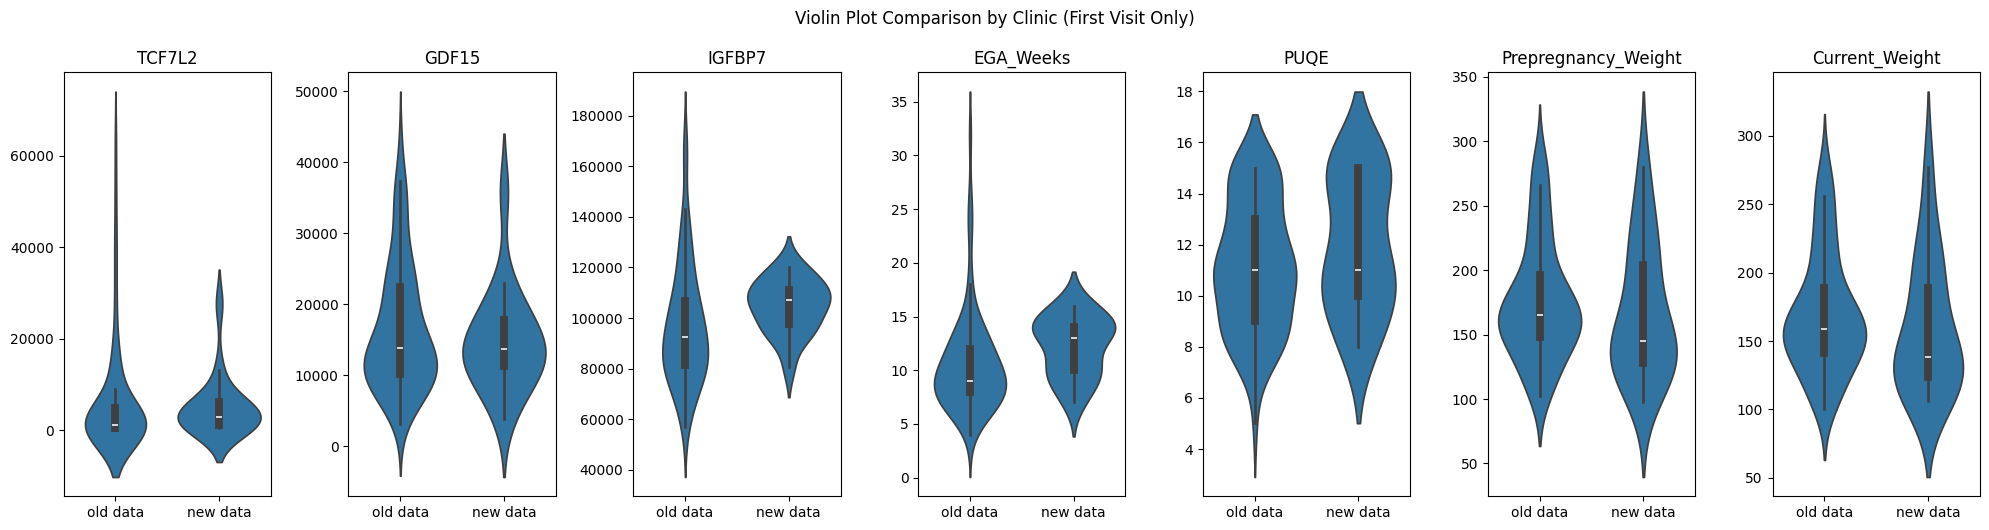

In [177]:
variables = ['TCF7L2', 'GDF15', 'IGFBP7', 'EGA_Weeks', 'PUQE', 'Prepregnancy_Weight', 'Current_Weight']

fig, axes = plt.subplots(nrows=1, ncols=len(variables), figsize=(20, 5), sharey=False)

for i, var in enumerate(variables):
    sns.violinplot(data=msc_first_visits_hg, x='Old_New', y=var, ax=axes[i])
    axes[i].set_title(var)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

plt.tight_layout()
plt.suptitle("Violin Plot Comparison by Clinic (First Visit Only)", y=1.05)
plt.show()

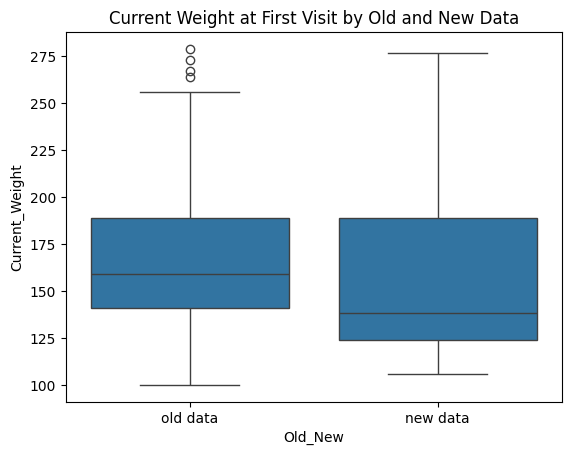

In [172]:
sns.boxplot(data=msc_data_first_visit, x='Old_New', y='Current_Weight')
plt.title('Current Weight at First Visit by Old and New Data')
plt.show()

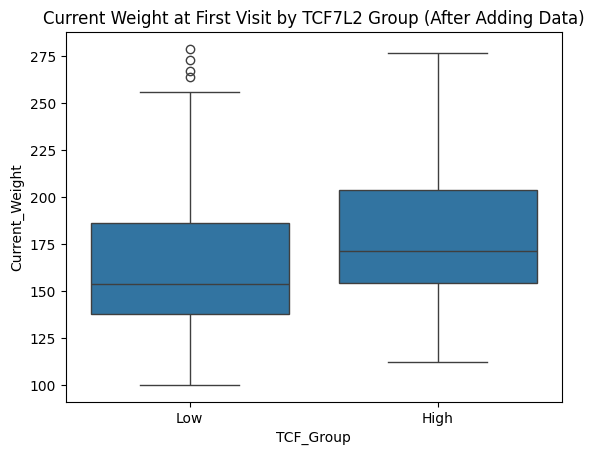

In [185]:
# Boxplot for all msc data (old and new) to compare distribution to old data
sns.boxplot(data=msc_first_visits_hg, x='TCF_Group', y='Current_Weight')
plt.title('Current Weight at First Visit by TCF7L2 Group (After Adding Data)')
plt.show()

/var/folders/nq/fg50vmnx4gzffp_j9phbgljh0000gn/T/ipykernel_45636/930076466.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  old_msc_data_first_visit['TCF_Group'] = ['Low' if x <= lowest_quartile_threshold_msc_old_first else 'High' for x in old_msc_data_first_visit['TCF7L2']]


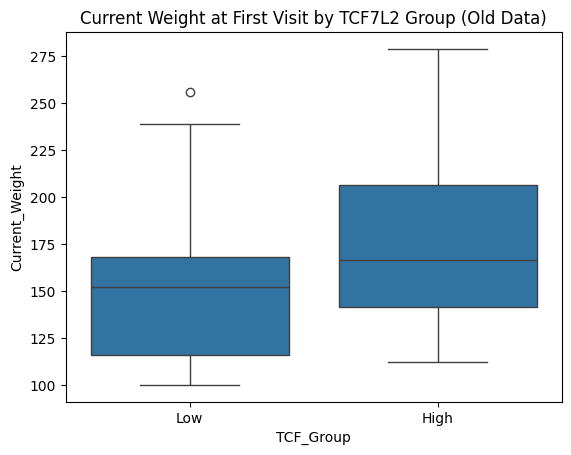

In [198]:
# Boxplot for old msc data to compare distribution of current weight to all (old and new) data

# Add TCF7L2 group column
lowest_quartile_threshold_msc_old_first = old_msc_data_first_visit['TCF7L2'].quantile(0.25)
old_msc_data_first_visit['TCF_Group'] = ['Low' if x <= lowest_quartile_threshold_msc_old_first else 'High' for x in old_msc_data_first_visit['TCF7L2']]

# Boxplot
sns.boxplot(data=old_msc_data_first_visit, x='TCF_Group', y='Current_Weight',  order=['Low', 'High'])
plt.title('Current Weight at First Visit by TCF7L2 Group (Old Data)')
plt.show()

#### Look at how the data breaks down across groups for new and old MSC data

In [202]:
# New data 

# Add TCF Group column for only new data
lowest_quartile_threshold_msc_new_first = new_msc_data_first_visit['TCF7L2'].quantile(0.25)
new_msc_data_first_visit['TCF_Group'] = ['Low' if x <= lowest_quartile_threshold_msc_new_first else 'High' for x in new_msc_data_first_visit['TCF7L2']]

new_msc_data_first_visit['TCF_Group'].value_counts()
new_msc_data_first_visit.groupby('TCF_Group')['Current_Weight'].describe()

/var/folders/nq/fg50vmnx4gzffp_j9phbgljh0000gn/T/ipykernel_45636/3474784420.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_msc_data_first_visit['TCF_Group'] = ['Low' if x <= lowest_quartile_threshold_msc_new_first else 'High' for x in new_msc_data_first_visit['TCF7L2']]


,count,mean,std,min,25%,50%,75%,max
TCF_Group,,,,,,,,
High,12.0,154.5,54.713302,106.0,120.75,129.0,169.5,277.0
Low,5.0,171.4,32.408332,138.0,138.00,181.0,189.0,211.0


In [203]:
# Old data 

old_msc_data_first_visit['TCF_Group'].value_counts()
old_msc_data_first_visit.groupby('TCF_Group')['Current_Weight'].describe()

,count,mean,std,min,25%,50%,75%,max
TCF_Group,,,,,,,,
High,56.0,176.428571,43.760728,112.0,141.75,166.5,206.25,279.0
Low,21.0,152.857143,40.868430,100.0,116.00,152.0,168.00,256.0


## Insights 
* The new data (n=17) group of patients is lighter overall than the old data which pulls the median down for that group. 

### Upper Quartile TCF7L2 vs. Rest (MSC Only)

In [91]:
msc_only_first_visits = first_visits[first_visits['Clinic'] == "msc"]
msc_only_second_visits = second_visits[second_visits['Clinic'] == "msc"]

# Filter the data for patients with HG 
msc_first_visits_hg = msc_only_first_visits[msc_only_first_visits['HG'] == 'yes']
msc_second_visits_hg = second_visits[second_visits['HG'] == 'yes']

# Calculate the 25th percentile (lowest quartile) of TCF7L2 for both first and second visits
highest_quartile_threshold_first = msc_first_visits_hg['TCF7L2'].quantile(0.75)
highest_quartile_threshold_second = msc_second_visits_hg['TCF7L2'].quantile(0.75)

# Split the data into High and Low TCF7L2 groups based on the lowest quartile threshold
msc_first_visits_hg['TCF_Group'] = ['Low' if x <= highest_quartile_threshold_first else 'High' for x in msc_first_visits_hg['TCF7L2']]
msc_second_visits_hg['TCF_Group'] = ['Low' if x <= highest_quartile_threshold_second else 'High' for x in msc_second_visits_hg['TCF7L2']]


# Define the metrics we want to analyze
metrics_to_analyze = [
    "EGA_Weeks", "HELP", "PUQE", "Prepregnancy_Weight", "Current_Weight", 
    "Weight_Change_from_Prepregnancy", "Weight_Change_from_Last_Visit", 
    "TCF7L2"
]

# Initialize an empty list to store the summary data
summary_data = []

# Function to calculate median, sample size, and perform normality check
def calculate_summary(data, metric):
    high_values = data[data['TCF_Group'] == 'High'][metric].dropna()
    low_values = data[data['TCF_Group'] == 'Low'][metric].dropna()
    
    # Sample sizes
    sample_size_high = len(high_values)
    sample_size_low = len(low_values)
    
    # Skip normality test if either group has fewer than 3 values
    if sample_size_high < 3 or sample_size_low < 3:
        test_used = "Not enough data for normality test"
        p_value = None
        significant = "Insufficient data"
        median_high = high_values.median() if sample_size_high > 0 else "N/A"
        median_low = low_values.median() if sample_size_low > 0 else "N/A"
        return median_high, median_low, significant, test_used, sample_size_high, sample_size_low, p_value
    
    # Check normality
    normal_high = shapiro(high_values)[1] >= 0.05
    normal_low = shapiro(low_values)[1] >= 0.05
    
    # Determine which test to use
    if normal_high and normal_low:
        # Use t-test if both groups are normal
        t_stat, p_value = ttest_ind(high_values, low_values, nan_policy='omit')
        test_used = "t-test"
    else:
        # Use Mann-Whitney U test if not normal
        t_stat, p_value = mannwhitneyu(high_values, low_values, alternative='two-sided')
        test_used = "Mann-Whitney U"

    # Calculate medians
    median_high = high_values.median()
    median_low = low_values.median()
    
    # Check if the difference is significant
    significant = "Yes" if p_value < 0.05 else "No"
    
    return median_high, median_low, significant, test_used, sample_size_high, sample_size_low, p_value

# Perform the analysis for each metric
for metric in metrics_to_analyze:
    # For first visit
    median_high_first, median_low_first, significant_first, test_used_first, sample_size_high_first, sample_size_low_first, p_value_first = calculate_summary(msc_first_visits_hg, metric)
    
    # For second visit
    median_high_second, median_low_second, significant_second, test_used_second, sample_size_high_second, sample_size_low_second, p_value_second = calculate_summary(msc_second_visits_hg, metric)

    # Add the results to the summary data list
    summary_data.append({
        "Metric": f"{metric} - 1st Visit High vs Low TCF7L2", 
        "Median (High)": median_high_first, 
        "Median (Low)": median_low_first,
        "Significant Difference (p < 0.05)": significant_first,
        "Test Used": test_used_first,
        "Sample Size (High)": sample_size_high_first,
        "Sample Size (Low)": sample_size_low_first,
        "p-value": p_value_first 
    })
    
    summary_data.append({
        "Metric": f"{metric} - 2nd Visit High vs Low TCF7L2", 
        "Median (High)": median_high_second, 
        "Median (Low)": median_low_second,
        "Significant Difference (p < 0.05)": significant_second,
        "Test Used": test_used_second,
        "Sample Size (High)": sample_size_high_second,
        "Sample Size (Low)": sample_size_low_second,
        "p-value": p_value_second 
    })

# Convert the list of dictionaries into a DataFrame
summary_table = pd.DataFrame(summary_data)

# Display the updated summary table
summary_table
# Export the table if needed
# summary_table.to_excel('tcf_high_rest_quartile_table_msc_only_june25.xlsx', index=False)


,Metric,Median (High),Median (Low),Significant Difference (p < 0.05),Test Used,Sample Size (High),Sample Size (Low),p-value
0,EGA_Weeks - 1st Visit High vs Low TCF7L2,9.5,10.0,No,Mann-Whitney U,22,72,8.364558e-01
1,EGA_Weeks - 2nd Visit High vs Low TCF7L2,13.05,12.1,No,Mann-Whitney U,20,61,7.799407e-01
2,HELP - 1st Visit High vs Low TCF7L2,31.5,34.0,No,Mann-Whitney U,22,73,1.938440e-01
3,HELP - 2nd Visit High vs Low TCF7L2,22.5,25.0,No,t-test,20,61,6.093903e-02
4,PUQE - 1st Visit High vs Low TCF7L2,10.0,11.0,Yes,Mann-Whitney U,25,73,3.783515e-02
5,PUQE - 2nd Visit High vs Low TCF7L2,7.0,9.0,No,Mann-Whitney U,20,60,1.416957e-01
6,Prepregnancy_Weight - 1st Visit High vs Low TC...,180.0,161.0,No,Mann-Whitney U,25,73,5.490983e-01
7,Prepregnancy_Weight - 2nd Visit High vs Low TC...,185.5,160.0,No,Mann-Whitney U,20,61,1.466172e-01
8,Current_Weight - 1st Visit High vs Low TCF7L2,171.5,154.0,No,Mann-Whitney U,22,72,2.642584e-01
9,Current_Weight - 2nd Visit High vs Low TCF7L2,177.0,156.0,No,Mann-Whitney U,20,61,1.109936e-01


### Lowest Quartile TCF7L2 vs. Rest (MSC Only - Outliers Removed)

In [88]:
# remove TCF7L2 outliers
msc_first_visits_hg_outliers_removed = msc_first_visits_hg[msc_first_visits_hg['TCF7L2'] < 15250]
msc_only_second_visits_hg_outliers_removed = msc_second_visits_hg[msc_second_visits_hg['TCF7L2'] < 15250]

# Calculate the 25th percentile (lowest quartile) of TCF7L2 for both first and second visits
lowest_quartile_threshold_first = msc_first_visits_hg_outliers_removed['TCF7L2'].quantile(0.25)
lowest_quartile_threshold_second = msc_only_second_visits_hg_outliers_removed['TCF7L2'].quantile(0.25)

# Split the data into High and Low TCF7L2 groups based on the lowest quartile threshold
msc_first_visits_hg_outliers_removed['TCF_Group'] = ['Low' if x <= lowest_quartile_threshold_first else 'High' for x in msc_first_visits_hg_outliers_removed['TCF7L2']]
msc_only_second_visits_hg_outliers_removed['TCF_Group'] = ['Low' if x <= lowest_quartile_threshold_second else 'High' for x in msc_only_second_visits_hg_outliers_removed['TCF7L2']]


# Define the metrics we want to analyze
metrics_to_analyze = [
    "EGA_Weeks", "HELP", "PUQE", "Prepregnancy_Weight", "Current_Weight", 
    "Weight_Change_from_Prepregnancy", "Weight_Change_from_Last_Visit", 
    "TCF7L2"
]

# Initialize an empty list to store the summary data
summary_data = []

# Function to calculate median, sample size, and perform normality check
def calculate_summary(data, metric):
    high_values = data[data['TCF_Group'] == 'High'][metric].dropna()
    low_values = data[data['TCF_Group'] == 'Low'][metric].dropna()
    
    # Sample sizes
    sample_size_high = len(high_values)
    sample_size_low = len(low_values)
    
    # Skip normality test if either group has fewer than 3 values
    if sample_size_high < 3 or sample_size_low < 3:
        test_used = "Not enough data for normality test"
        p_value = None
        significant = "Insufficient data"
        median_high = high_values.median() if sample_size_high > 0 else "N/A"
        median_low = low_values.median() if sample_size_low > 0 else "N/A"
        return median_high, median_low, significant, test_used, sample_size_high, sample_size_low, p_value
    
    # Check normality
    normal_high = shapiro(high_values)[1] >= 0.05
    normal_low = shapiro(low_values)[1] >= 0.05
    
    # Determine which test to use
    if normal_high and normal_low:
        # Use t-test if both groups are normal
        t_stat, p_value = ttest_ind(high_values, low_values, nan_policy='omit')
        test_used = "t-test"
    else:
        # Use Mann-Whitney U test if not normal
        t_stat, p_value = mannwhitneyu(high_values, low_values, alternative='two-sided')
        test_used = "Mann-Whitney U"

    # Calculate medians
    median_high = high_values.median()
    median_low = low_values.median()
    
    # Check if the difference is significant
    significant = "Yes" if p_value < 0.05 else "No"
    
    return median_high, median_low, significant, test_used, sample_size_high, sample_size_low, p_value

# Perform the analysis for each metric
for metric in metrics_to_analyze:
    # For first visit
    median_high_first, median_low_first, significant_first, test_used_first, sample_size_high_first, sample_size_low_first, p_value_first = calculate_summary(msc_first_visits_hg_outliers_removed, metric)
    
    # For second visit
    median_high_second, median_low_second, significant_second, test_used_second, sample_size_high_second, sample_size_low_second, p_value_second = calculate_summary(msc_only_second_visits_hg_outliers_removed, metric)

    # Add the results to the summary data list
    summary_data.append({
        "Metric": f"{metric} - 1st Visit High vs Low TCF7L2", 
        "Median (High)": median_high_first, 
        "Median (Low)": median_low_first,
        "Significant Difference (p < 0.05)": significant_first,
        "Test Used": test_used_first,
        "Sample Size (High)": sample_size_high_first,
        "Sample Size (Low)": sample_size_low_first,
        "p-value": p_value_first 
    })
    
    summary_data.append({
        "Metric": f"{metric} - 2nd Visit High vs Low TCF7L2", 
        "Median (High)": median_high_second, 
        "Median (Low)": median_low_second,
        "Significant Difference (p < 0.05)": significant_second,
        "Test Used": test_used_second,
        "Sample Size (High)": sample_size_high_second,
        "Sample Size (Low)": sample_size_low_second,
        "p-value": p_value_second 
    })

# Convert the list of dictionaries into a DataFrame
summary_table = pd.DataFrame(summary_data)

# Display the updated summary table
summary_table
# Export the table if needed
# summary_table.to_excel('tcf_high_low_quartile_table_msc_only_june25.xlsx', index=False)


/var/folders/nq/fg50vmnx4gzffp_j9phbgljh0000gn/T/ipykernel_45636/3015794528.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msc_first_visits_hg_outliers_removed['TCF_Group'] = ['Low' if x <= lowest_quartile_threshold_first else 'High' for x in msc_first_visits_hg_outliers_removed['TCF7L2']]
/var/folders/nq/fg50vmnx4gzffp_j9phbgljh0000gn/T/ipykernel_45636/3015794528.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msc_only_second_visits_hg_outliers_removed['TCF_Group'] = ['Low' if x <= lowest_quarti

,Metric,Median (High),Median (Low),Significant Difference (p < 0.05),Test Used,Sample Size (High),Sample Size (Low),p-value
0,EGA_Weeks - 1st Visit High vs Low TCF7L2,10.0,10.0,No,Mann-Whitney U,63,21,7.279265e-01
1,EGA_Weeks - 2nd Visit High vs Low TCF7L2,12.2,13.3,No,Mann-Whitney U,54,19,4.392793e-01
2,HELP - 1st Visit High vs Low TCF7L2,34.0,35.0,No,Mann-Whitney U,63,22,7.629367e-01
3,HELP - 2nd Visit High vs Low TCF7L2,25.5,23.0,No,t-test,54,19,5.804434e-01
4,PUQE - 1st Visit High vs Low TCF7L2,11.0,13.0,No,Mann-Whitney U,65,21,7.028201e-02
5,PUQE - 2nd Visit High vs Low TCF7L2,9.0,8.5,No,Mann-Whitney U,54,18,6.613133e-01
6,Prepregnancy_Weight - 1st Visit High vs Low TC...,163.0,165.0,No,Mann-Whitney U,65,21,3.146751e-01
7,Prepregnancy_Weight - 2nd Visit High vs Low TC...,159.5,165.0,No,Mann-Whitney U,54,19,9.398529e-01
8,Current_Weight - 1st Visit High vs Low TCF7L2,159.0,152.0,No,Mann-Whitney U,62,22,2.070717e-01
9,Current_Weight - 2nd Visit High vs Low TCF7L2,157.5,159.0,No,Mann-Whitney U,54,19,9.099021e-01


## Insights
* When removing the madres data, we still see statistical significance between the difference in median PUQE scores for low and high TCFL2 level groups. But the stat sig went away for the 1st visit weight when compared to previous analysis.
    - We don't see stat sig when incorporating the madres data for either analysis. 
* For lowest quartile TCF7L2 levels vs rest:
    - PUQE score is lower with higher levels of TCF7L2 supporting hypothesis that TCF7L2 is protective
* For highest quartile TCFL2 levels vs rest:
    - PUQE score is also lower with higher levels of TCF7L2 supporting hypothesis that TCF7L2 is protective 

# Madres vs MSC Data
* only look at patients with HG and first visit for accurate comparison

In [103]:
madres_data = cleaned_visits[cleaned_visits['Clinic'] == 'madres']
madres_data_hg = madres_data[madres_data['HG'] == 'yes']
msc_data = cleaned_visits[cleaned_visits['Clinic'] == 'msc']
msc_data_first_visit = msc_data[msc_data['Visit_Number'] == 1]

In [104]:
madres_data_hg.describe()

,Date,Visit_Number,TCF7L2,GDF15,IGFBP7,EGA_Weeks,HELP,PUQE,Prepregnancy_Weight,Current_Weight,Weight_Change_from_Prepregnancy,Weight_Change_from_Last_Visit,Weight_Difference_from_Prepreg (%),Weight_Difference_from_Last
count,0,7.0,7.000000,7.000000,7.000000,7.000000,0.0,7.000000,7.000000,0.0,0.0,0.0,0.0,0.0
mean,NaT,1.0,16078.360490,14793.471046,116876.436106,9.938300,NaN,13.428571,152.882857,NaN,NaN,NaN,NaN,NaN
min,NaT,1.0,996.911824,8682.455324,100929.177411,7.570000,NaN,13.000000,130.022000,NaN,NaN,NaN,NaN,NaN
25%,NaT,1.0,1133.298175,12289.380859,103583.357348,8.000000,NaN,13.000000,139.022351,NaN,NaN,NaN,NaN,NaN
50%,NaT,1.0,1722.376137,13402.990119,110847.711827,10.857000,NaN,13.000000,155.026400,NaN,NaN,NaN,NaN,NaN
75%,NaT,1.0,10369.317938,18142.890371,116474.286412,11.213550,NaN,13.500000,164.028450,NaN,NaN,NaN,NaN,NaN
max,NaT,1.0,86824.003245,20604.309419,166242.875982,12.714000,NaN,15.000000,179.030000,NaN,NaN,NaN,NaN,NaN
std,NaN,0.0,31814.286522,4270.503442,22673.569435,2.050157,NaN,0.786796,18.200989,NaN,NaN,NaN,NaN,NaN


In [105]:
msc_data_first_visit.describe()

,Date,Visit_Number,TCF7L2,GDF15,IGFBP7,EGA_Weeks,HELP,PUQE,Prepregnancy_Weight,Current_Weight,Weight_Change_from_Prepregnancy,Weight_Change_from_Last_Visit,Weight_Difference_from_Prepreg (%),Weight_Difference_from_Last
count,99,99.0,99.000000,99.000000,99.000000,94.000000,95.000000,98.000000,98.000000,94.000000,93.000000,0.0,93.000000,0.0
mean,2024-06-11 01:12:43.636363520,1.0,6206.691867,16270.712661,98299.330396,10.897872,34.726316,11.275510,174.351020,168.095745,-6.032258,NaN,-3.244629,NaN
min,2023-10-16 00:00:00,1.0,184.924000,3176.985931,56815.903035,4.000000,18.000000,5.000000,98.000000,100.000000,-33.000000,NaN,-21.481481,NaN
25%,2024-04-18 12:00:00,1.0,716.578500,10143.571525,82163.578833,8.000000,29.000000,9.000000,142.750000,138.000000,-11.000000,NaN,-5.990783,NaN
50%,2024-05-16 00:00:00,1.0,1264.294910,13753.280000,95368.026500,10.000000,34.000000,11.000000,164.500000,157.900000,-6.000000,NaN,-3.759398,NaN
75%,2024-06-18 00:00:00,1.0,5422.447048,20801.747166,109268.445153,13.000000,40.000000,13.000000,196.750000,189.000000,-1.000000,NaN,-0.904977,NaN
max,2025-10-09 00:00:00,1.0,63650.610000,42603.978641,169852.600000,32.000000,55.000000,15.000000,290.000000,279.000000,23.000000,NaN,15.333333,NaN
std,NaN,0.0,11681.281762,8594.234645,22176.038985,4.459109,7.897538,2.547611,47.055931,44.829126,9.040887,NaN,5.712270,NaN


### Violin Plots
* compare distribution of variables by clinic

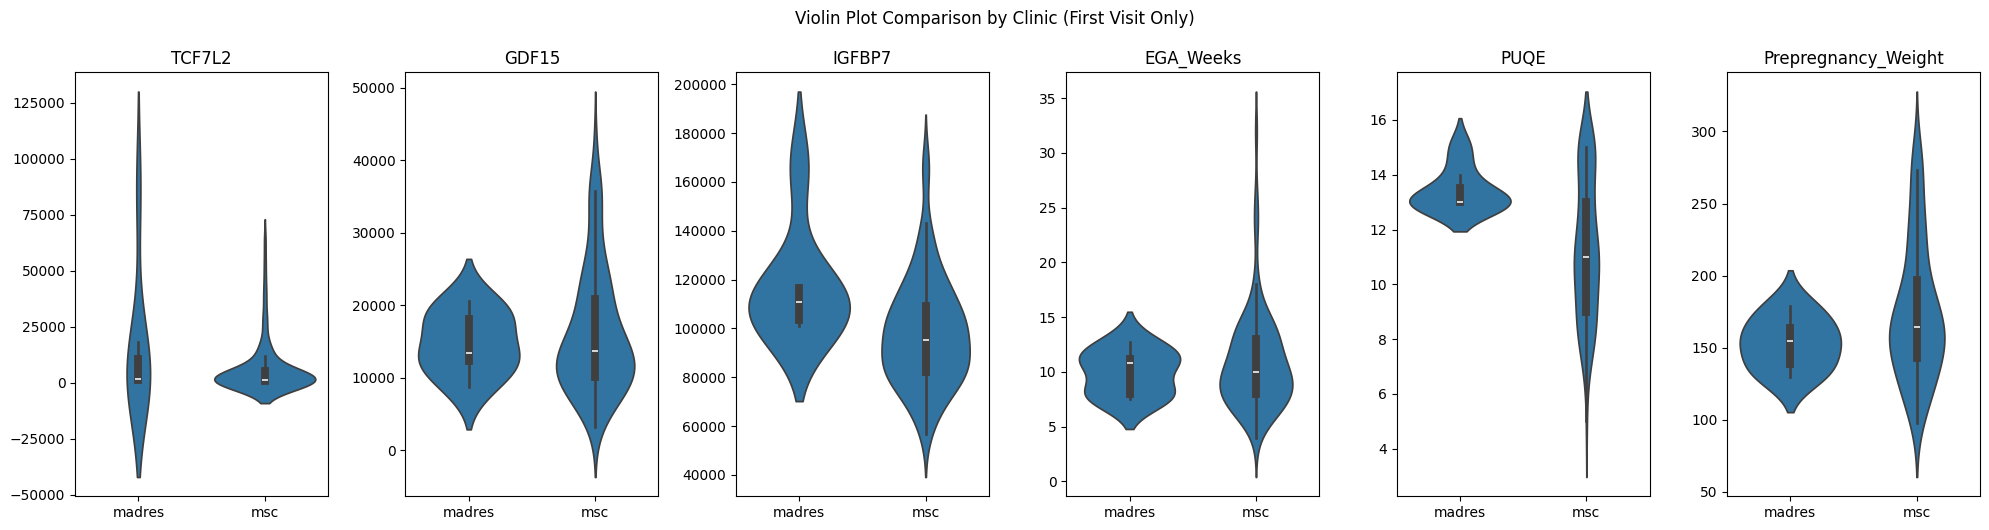

In [169]:
variables = ['TCF7L2', 'GDF15', 'IGFBP7', 'EGA_Weeks', 'PUQE', 'Prepregnancy_Weight']

fig, axes = plt.subplots(nrows=1, ncols=len(variables), figsize=(20, 5), sharey=False)

for i, var in enumerate(variables):
    sns.violinplot(data=first_visits_hg, x='Clinic', y=var, ax=axes[i])
    axes[i].set_title(var)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

plt.tight_layout()
plt.suptitle("Violin Plot Comparison by Clinic (First Visit Only)", y=1.05)
plt.show()


## Insights
* **TCF7L2**
    - Madres data is very skewed due to large outlier at 86,824.
* **GDF15**
    - GDF15 levels are slightly lower in madres, but much more tightly distributed.
* **IGFBP7**
    - Madres shows higher average IGFBP7 but similar variability.
* **EGA_Weeks**
    - Both clinics have similar gestational age, though MSC is slightly higher and more variable.
* **PUQE**
    - PUQE scores are higher in MADRES, suggesting more severe symptoms.
* **Prepregnancy_Weight**
    - MSC patients tend to be heavier pre-pregnancy with greater variability.
* **Sample Size Difference:** MADRES (n=7) is very small, so distributions may not be reliable for broad comparisons. MSC sample is n=99.
* **Skewed Biomarkers:** TCF7L2 especially is highly skewed in MADRES — suggest trimming outliers before visualization.


<br> Clinic differences (like measurement protocols, population differences, timing) could confound the results. So, when interpreting the comparison, mention that HG data is pooled from two clinics but non-HG is from one clinic only and make sure to clearly state that MSC data dominates data for those with HG. 


## Protein Level x EGA by HG Status - First Visit Only
* Remove outliers

### EGA vs TCF7L2 by HG Status

Text(0.5, 1.0, 'TCF7L2 Levels over EGA by HG Status')

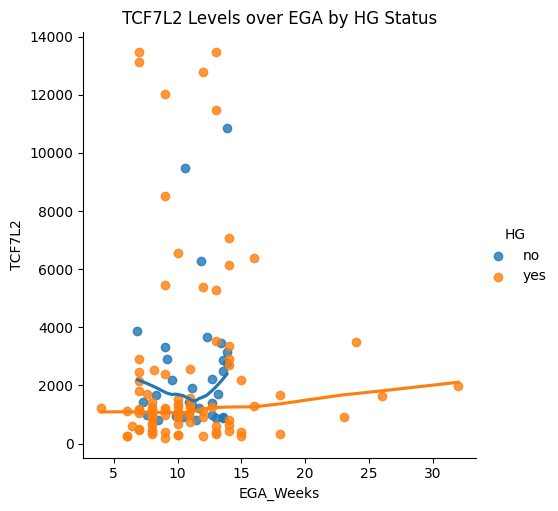

In [127]:
# use df with tcf outliers removed: first_visits_tcf_outliers_removed

sns.lmplot(data=first_visits_tcf_outliers_removed, x='EGA_Weeks', y='TCF7L2', hue='HG', lowess=True)
plt.title('TCF7L2 Levels over EGA by HG Status')

### EGA vs IGFBP7 by HG Status

Text(0.5, 1.0, 'IGFBP7 Levels over EGA by HG Status')

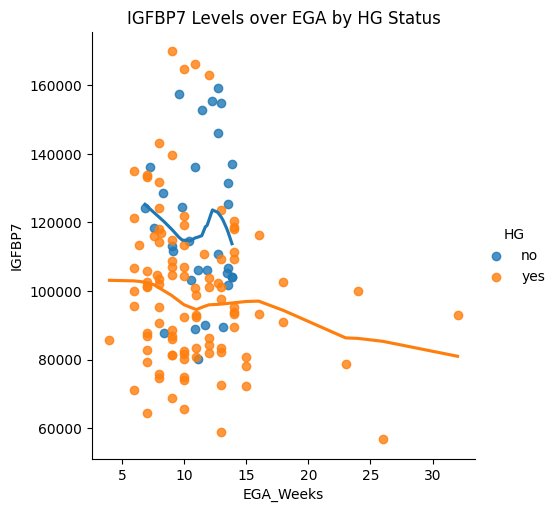

In [130]:
sns.lmplot(data=first_visits, x='EGA_Weeks', y='IGFBP7', hue='HG', lowess=True)
plt.title('IGFBP7 Levels over EGA by HG Status')

### EGA vs GDF15 by HG Status

Text(0.5, 1.0, 'GDF15 Levels over EGA by HG Status')

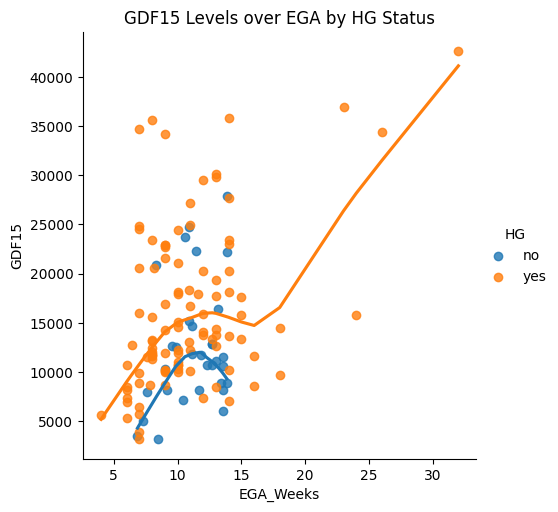

In [131]:
sns.lmplot(data=first_visits, x='EGA_Weeks', y='GDF15', hue='HG', lowess=True)
plt.title('GDF15 Levels over EGA by HG Status')

### TCF vs EGA

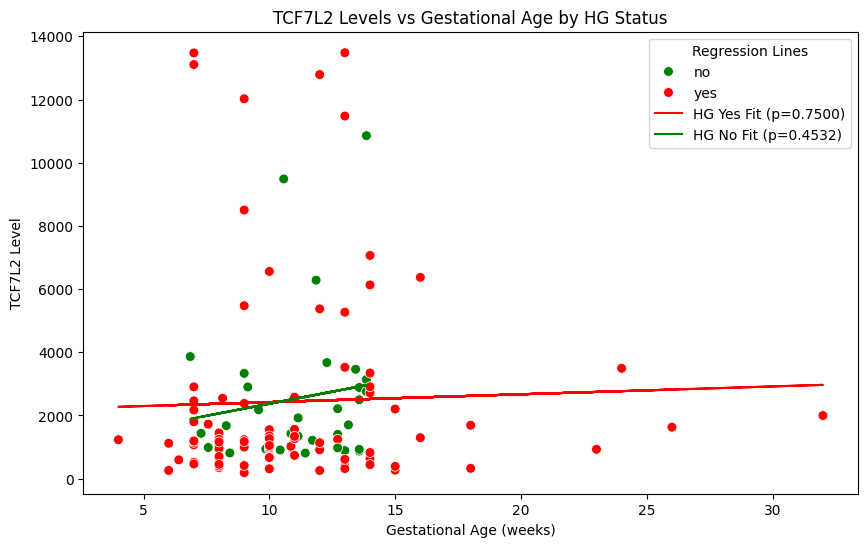

In [138]:
# Drop rows with missing values in EGA_Weeks or your protein of interest, e.g., TCF7L2
df_clean = first_visits_tcf_outliers_removed.dropna(subset=['EGA_Weeks', 'TCF7L2', 'HG'])

# Scatter plot setup
plt.figure(figsize=(10, 6))

# Plot points colored by HG status ('Yes' / 'No')
sns.scatterplot(
    x='EGA_Weeks',
    y='TCF7L2',
    data=df_clean,
    hue='HG',
    palette={'yes': 'red', 'no': 'green'},
    s=50
)

# Separate into two groups by HG status
hg_yes = df_clean[df_clean['HG'] == 'yes']
hg_no = df_clean[df_clean['HG'] == 'no']

# Linear regression & line of best fit for HG Yes
slope_yes, intercept_yes, r_value_yes, p_value_yes, std_err_yes = linregress(hg_yes['EGA_Weeks'], hg_yes['TCF7L2'])
plt.plot(
    hg_yes['EGA_Weeks'],
    slope_yes * hg_yes['EGA_Weeks'] + intercept_yes,
    color='red',
    label=f'HG Yes Fit (p={p_value_yes:.4f})'
)

# Linear regression & line of best fit for HG No
slope_no, intercept_no, r_value_no, p_value_no, std_err_no = linregress(hg_no['EGA_Weeks'], hg_no['TCF7L2'])
plt.plot(
    hg_no['EGA_Weeks'],
    slope_no * hg_no['EGA_Weeks'] + intercept_no,
    color='green',
    label=f'HG No Fit (p={p_value_no:.4f})'
)

# Labels and legend
plt.title('TCF7L2 Levels vs Gestational Age by HG Status')
plt.xlabel('Gestational Age (weeks)')
plt.ylabel('TCF7L2 Level')
plt.legend(title='Regression Lines')
plt.show()

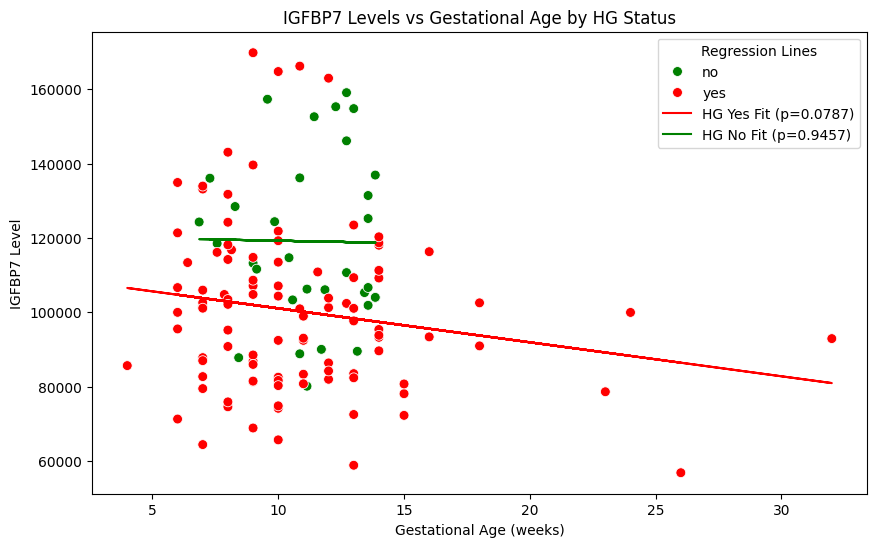

In [139]:
# Drop rows with missing values in EGA_Weeks or your protein of interest, e.g., IGFBP7
df_clean = first_visits.dropna(subset=['EGA_Weeks', 'IGFBP7', 'HG'])

# Scatter plot setup
plt.figure(figsize=(10, 6))

# Plot points colored by HG status ('Yes' / 'No')
sns.scatterplot(
    x='EGA_Weeks',
    y='IGFBP7',
    data=df_clean,
    hue='HG',
    palette={'yes': 'red', 'no': 'green'},
    s=50
)

# Separate into two groups by HG status
hg_yes = df_clean[df_clean['HG'] == 'yes']
hg_no = df_clean[df_clean['HG'] == 'no']

# Linear regression & line of best fit for HG Yes
slope_yes, intercept_yes, r_value_yes, p_value_yes, std_err_yes = linregress(hg_yes['EGA_Weeks'], hg_yes['IGFBP7'])
plt.plot(
    hg_yes['EGA_Weeks'],
    slope_yes * hg_yes['EGA_Weeks'] + intercept_yes,
    color='red',
    label=f'HG Yes Fit (p={p_value_yes:.4f})'
)

# Linear regression & line of best fit for HG No
slope_no, intercept_no, r_value_no, p_value_no, std_err_no = linregress(hg_no['EGA_Weeks'], hg_no['IGFBP7'])
plt.plot(
    hg_no['EGA_Weeks'],
    slope_no * hg_no['EGA_Weeks'] + intercept_no,
    color='green',
    label=f'HG No Fit (p={p_value_no:.4f})'
)

# Labels and legend
plt.title('IGFBP7 Levels vs Gestational Age by HG Status')
plt.xlabel('Gestational Age (weeks)')
plt.ylabel('IGFBP7 Level')
plt.legend(title='Regression Lines')
plt.show()

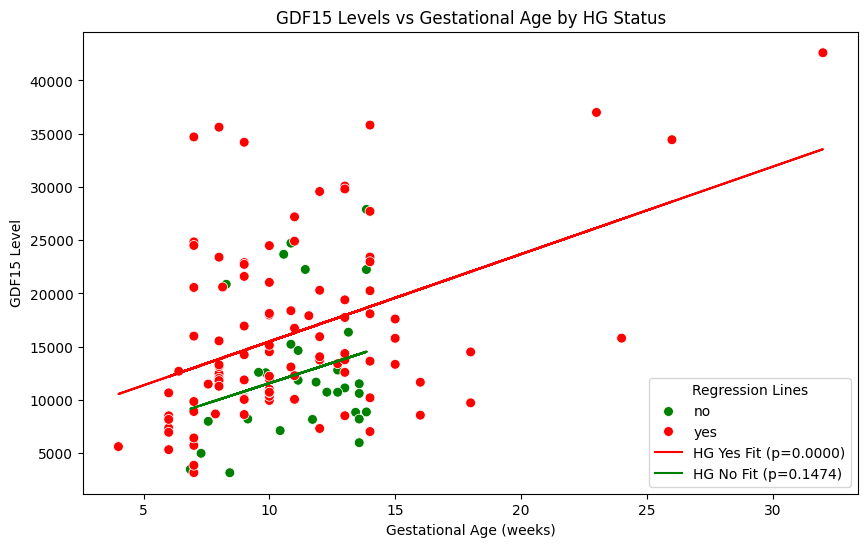

In [140]:
# Drop rows with missing values in EGA_Weeks or your protein of interest, e.g., GDF15
df_clean = first_visits.dropna(subset=['EGA_Weeks', 'GDF15', 'HG'])

# Scatter plot setup
plt.figure(figsize=(10, 6))

# Plot points colored by HG status ('Yes' / 'No')
sns.scatterplot(
    x='EGA_Weeks',
    y='GDF15',
    data=df_clean,
    hue='HG',
    palette={'yes': 'red', 'no': 'green'},
    s=50
)

# Separate into two groups by HG status
hg_yes = df_clean[df_clean['HG'] == 'yes']
hg_no = df_clean[df_clean['HG'] == 'no']

# Linear regression & line of best fit for HG Yes
slope_yes, intercept_yes, r_value_yes, p_value_yes, std_err_yes = linregress(hg_yes['EGA_Weeks'], hg_yes['GDF15'])
plt.plot(
    hg_yes['EGA_Weeks'],
    slope_yes * hg_yes['EGA_Weeks'] + intercept_yes,
    color='red',
    label=f'HG Yes Fit (p={p_value_yes:.4f})'
)

# Linear regression & line of best fit for HG No
slope_no, intercept_no, r_value_no, p_value_no, std_err_no = linregress(hg_no['EGA_Weeks'], hg_no['GDF15'])
plt.plot(
    hg_no['EGA_Weeks'],
    slope_no * hg_no['EGA_Weeks'] + intercept_no,
    color='green',
    label=f'HG No Fit (p={p_value_no:.4f})'
)

# Labels and legend
plt.title('GDF15 Levels vs Gestational Age by HG Status')
plt.xlabel('Gestational Age (weeks)')
plt.ylabel('GDF15 Level')
plt.legend(title='Regression Lines')
plt.show()

## Protein Level x EGA by HG Status - All Visits
* Remove outliers

In [144]:
cleaned_visits_tcf_outliers_removed = cleaned_visits[cleaned_visits['TCF7L2'] < 15250]

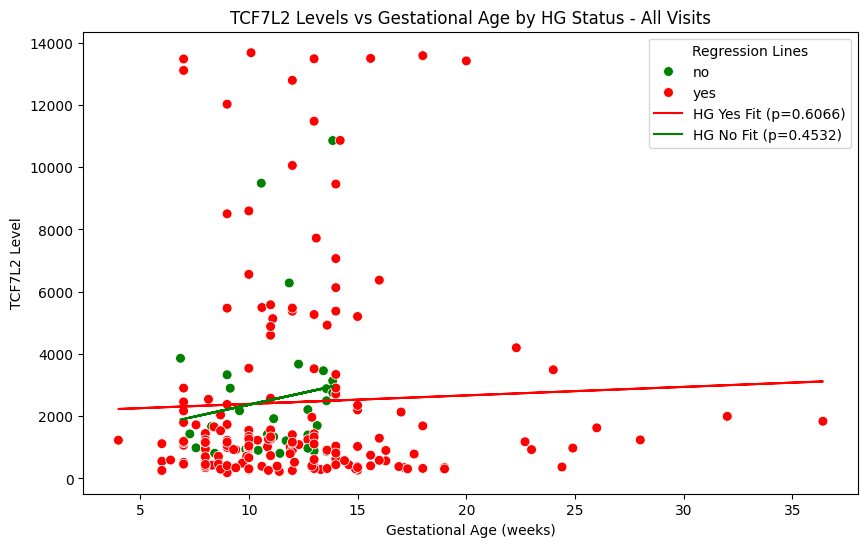

In [150]:
# Drop rows with missing values in EGA_Weeks or your protein of interest, e.g., TCF7L2
df_clean = cleaned_visits_tcf_outliers_removed.dropna(subset=['EGA_Weeks', 'TCF7L2', 'HG'])

# Scatter plot setup
plt.figure(figsize=(10, 6))

# Plot points colored by HG status ('Yes' / 'No')
sns.scatterplot(
    x='EGA_Weeks',
    y='TCF7L2',
    data=df_clean,
    hue='HG',
    palette={'yes': 'red', 'no': 'green'},
    s=50
)

# Separate into two groups by HG status
hg_yes = df_clean[df_clean['HG'] == 'yes']
hg_no = df_clean[df_clean['HG'] == 'no']

# Linear regression & line of best fit for HG Yes
slope_yes, intercept_yes, r_value_yes, p_value_yes, std_err_yes = linregress(hg_yes['EGA_Weeks'], hg_yes['TCF7L2'])
plt.plot(
    hg_yes['EGA_Weeks'],
    slope_yes * hg_yes['EGA_Weeks'] + intercept_yes,
    color='red',
    label=f'HG Yes Fit (p={p_value_yes:.4f})'
)

# Linear regression & line of best fit for HG No
slope_no, intercept_no, r_value_no, p_value_no, std_err_no = linregress(hg_no['EGA_Weeks'], hg_no['TCF7L2'])
plt.plot(
    hg_no['EGA_Weeks'],
    slope_no * hg_no['EGA_Weeks'] + intercept_no,
    color='green',
    label=f'HG No Fit (p={p_value_no:.4f})'
)

# Labels and legend
plt.title('TCF7L2 Levels vs Gestational Age by HG Status - All Visits')
plt.xlabel('Gestational Age (weeks)')
plt.ylabel('TCF7L2 Level')
plt.legend(title='Regression Lines')
plt.show()

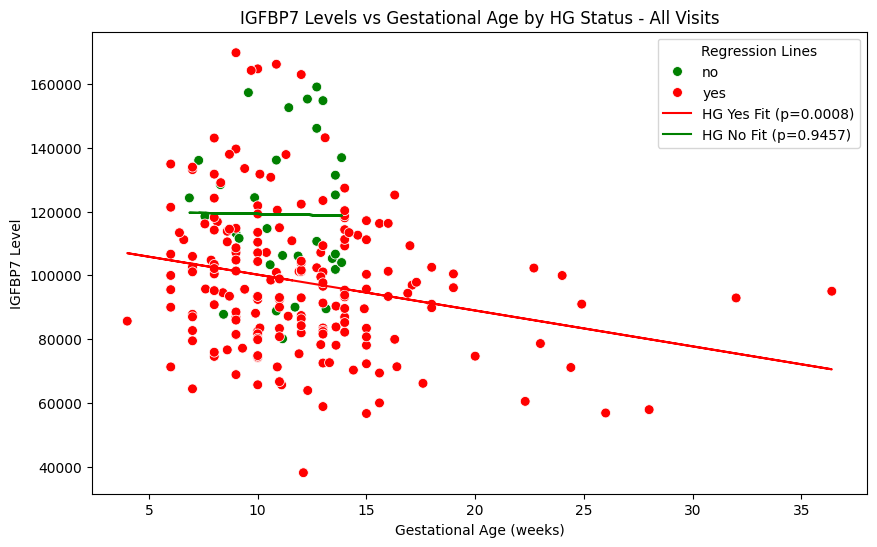

In [148]:
# Drop rows with missing values in EGA_Weeks or your protein of interest, e.g., IGFBP7
df_clean = cleaned_visits.dropna(subset=['EGA_Weeks', 'IGFBP7', 'HG'])

# Scatter plot setup
plt.figure(figsize=(10, 6))

# Plot points colored by HG status ('Yes' / 'No')
sns.scatterplot(
    x='EGA_Weeks',
    y='IGFBP7',
    data=df_clean,
    hue='HG',
    palette={'yes': 'red', 'no': 'green'},
    s=50
)

# Separate into two groups by HG status
hg_yes = df_clean[df_clean['HG'] == 'yes']
hg_no = df_clean[df_clean['HG'] == 'no']

# Linear regression & line of best fit for HG Yes
slope_yes, intercept_yes, r_value_yes, p_value_yes, std_err_yes = linregress(hg_yes['EGA_Weeks'], hg_yes['IGFBP7'])
plt.plot(
    hg_yes['EGA_Weeks'],
    slope_yes * hg_yes['EGA_Weeks'] + intercept_yes,
    color='red',
    label=f'HG Yes Fit (p={p_value_yes:.4f})'
)

# Linear regression & line of best fit for HG No
slope_no, intercept_no, r_value_no, p_value_no, std_err_no = linregress(hg_no['EGA_Weeks'], hg_no['IGFBP7'])
plt.plot(
    hg_no['EGA_Weeks'],
    slope_no * hg_no['EGA_Weeks'] + intercept_no,
    color='green',
    label=f'HG No Fit (p={p_value_no:.4f})'
)

# Labels and legend
plt.title('IGFBP7 Levels vs Gestational Age by HG Status - All Visits')
plt.xlabel('Gestational Age (weeks)')
plt.ylabel('IGFBP7 Level')
plt.legend(title='Regression Lines')
plt.show()

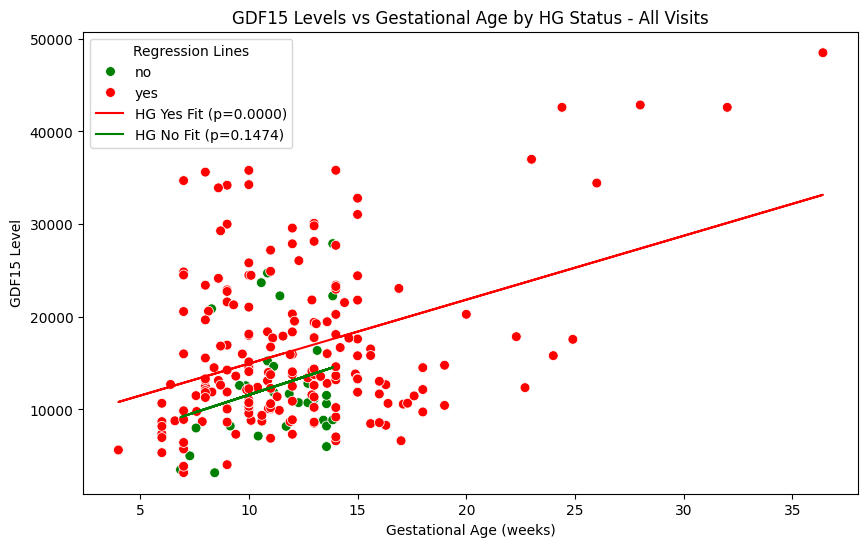

In [149]:
# Drop rows with missing values in EGA_Weeks or your protein of interest, e.g., GDF15
df_clean = cleaned_visits.dropna(subset=['EGA_Weeks', 'GDF15', 'HG'])

# Scatter plot setup
plt.figure(figsize=(10, 6))

# Plot points colored by HG status ('Yes' / 'No')
sns.scatterplot(
    x='EGA_Weeks',
    y='GDF15',
    data=df_clean,
    hue='HG',
    palette={'yes': 'red', 'no': 'green'},
    s=50
)

# Separate into two groups by HG status
hg_yes = df_clean[df_clean['HG'] == 'yes']
hg_no = df_clean[df_clean['HG'] == 'no']

# Linear regression & line of best fit for HG Yes
slope_yes, intercept_yes, r_value_yes, p_value_yes, std_err_yes = linregress(hg_yes['EGA_Weeks'], hg_yes['GDF15'])
plt.plot(
    hg_yes['EGA_Weeks'],
    slope_yes * hg_yes['EGA_Weeks'] + intercept_yes,
    color='red',
    label=f'HG Yes Fit (p={p_value_yes:.4f})'
)

# Linear regression & line of best fit for HG No
slope_no, intercept_no, r_value_no, p_value_no, std_err_no = linregress(hg_no['EGA_Weeks'], hg_no['GDF15'])
plt.plot(
    hg_no['EGA_Weeks'],
    slope_no * hg_no['EGA_Weeks'] + intercept_no,
    color='green',
    label=f'HG No Fit (p={p_value_no:.4f})'
)

# Labels and legend
plt.title('GDF15 Levels vs Gestational Age by HG Status - All Visits')
plt.xlabel('Gestational Age (weeks)')
plt.ylabel('GDF15 Level')
plt.legend(title='Regression Lines')
plt.show()